# Final Year Project

The Neural Architecture Search technique that uses Dispersive Flies Optimisation algorithm to find the best neural architecture for semantic segmentation of a medical image is implemented in this notebook.

## Required Imports

Firstly, import the required libraries

In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 44.9 MB/s eta 0:00:00


In [2]:
import os
import tarfile
import zipfile
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import random
import nibabel as nib
import matplotlib.pyplot as plt

from typing import Union
from scipy import ndimage
from tensorflow.keras import layers
from tensorflow import keras
from IPython.display import clear_output
from tensorflow.keras import backend as K

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# np.random.seed = 42

## Final implementation

In [4]:
class NasMedSeg:
    _BATCH_SIZE: int
    _REDUCED_BATCH_SIZE: int
    _EPOCHS: int
    _OPTIMIZER: str

    _input_shape: tuple

    _train_ds: Union[None, tf.data.Dataset]
    _validation_ds: Union[None, tf.data.Dataset]
    _train_ds_reduced: Union[None, tf.data.Dataset]
    _validation_ds_reduced: Union[None, tf.data.Dataset]

    _operations = operations = [
        [1, 3, "relu"],
        [1, 3, "mish"],
        [1, 3, "IN", "relu"],
        [1, 3, "IN", "mish"],
        [1, 5, "relu"],
        [1, 5, "mish"],
        [1, 5, "IN", "relu"],
        [1, 5, "IN", "mish"],
        [0, 3, "relu"],
        [0, 3, "mish"],
        [0, 3, "IN", "relu"],
        [0, 3, "IN", "mish"],
        [0, 5, "relu"],
        [0, 5, "mish"],
        [0, 5, "IN", "relu"],
        [0, 5, "IN", "mish"],
    ]

    _connections = {
        1: [[0]],
        2: [[0], [1]],
        3: [[0], [1], [2], [1, 2]],
        4: [[0], [1], [2], [3], [1, 2], [1, 3], [2, 3], [1, 2, 3]],
        5: [
            [0], [1], [2], [3], [4], [1, 2], [1, 3], [1, 4],
            [2, 3], [2, 4], [3, 4], [1, 2, 3], [2, 3, 4], [3, 4, 1], [4, 1, 2], [1, 2, 3, 4]
        ]
    }

    _augmentation_techniques = [
        None,  # None represents no augmentation technique - original dataset
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomFlip("vertical"),
        tf.keras.layers.RandomRotation(0.25),
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ]

    def __init__(self,
                 input_shape: tuple,
                 batch_size: int = 20,
                 reduced_batch_size: int = 16,
                 epochs: int = 25,
                 optimizer: str = 'adam'):

        self._input_shape = input_shape

        self._BATCH_SIZE = batch_size
        self._REDUCED_BATCH_SIZE = reduced_batch_size
        self._EPOCHS = epochs
        self._OPTIMIZER = optimizer

        self._train_ds = None
        self._validation_ds = None
        self._train_ds_reduced = None
        self._validation_ds_reduced = None

    def __initialise_fly(self, population: np.ndarray, fly_idx: int) -> None:
        for i in range(7):
            population[fly_idx, i, 0] = random.randint(0, len(self._operations) - 1)
            population[fly_idx, i, 1] = random.randint(0, len(self._connections[1]) - 1)
            population[fly_idx, i, 2] = random.randint(0, len(self._connections[2]) - 1)
            population[fly_idx, i, 3] = random.randint(0, len(self._connections[3]) - 1)
            population[fly_idx, i, 4] = random.randint(0, len(self._connections[4]) - 1)
            population[fly_idx, i, 5] = random.randint(0, len(self._connections[5]) - 1)

    def __initialise_population(self, pop_size: int) -> np.ndarray:
        """It generates population of specified size"""

        population = np.empty((pop_size, 7, 6))
        for i in range(pop_size):
            self.__initialise_fly(population, i)

        return population.astype(int)

    def __update_fly(self,
                     new_population: np.ndarray,
                     population: np.ndarray,
                     fly_idx: int,
                     best_neighbour_i: int,
                     best_fly_i: int):
        """It updates fly"""

        for i in range(7):
            # Firstly update first position from the column - it indicates the operation used in every node
            new_population[fly_idx, i, 0] = constrain(
                min_v=0,
                max_v=len(self._operations) - 1,
                value=np.round(population[best_neighbour_i, i, 0] + np.random.uniform() * (
                            population[best_fly_i, i, 0] - population[fly_idx, i, 0])).astype(int)
            )

            # Then update 5 positions representing blocks of the architecture
            for j in range(1, 6):
                new_population[fly_idx, i, j] = constrain(
                    min_v=0,
                    max_v=len(self._connections[j]) - 1,
                    value=np.round(population[best_neighbour_i, i, j] + np.random.uniform() * (
                                population[best_fly_i, i, j] - population[fly_idx, i, j])).astype(int)
                )

    def __apply_operations(self, node: tf.keras.layers.Layer, operation: list, node_name: str, filters: tuple):
        """It applies operations specified by the first number of the block vector"""
        conv = layers.Conv2D(
            filters,
            operation[1],
            padding="same",
            name=node_name,
        )

        # Choose activation function
        if operation[2] == 'relu' or (len(operation) == 4 and operation[3] == 'relu'):
            activation = layers.ReLU()
        elif operation[2] == 'mish' or (len(operation) == 4 and operation[3] == 'mish'):
            activation = tfa.activations.mish
        else:
            raise ValueError()

        # Choose normalization_function
        normalization = None
        if operation[2] == 'IN':
            normalization = tfa.layers.InstanceNormalization(
                axis=3,
                center=True,
                scale=True,
                beta_initializer="random_uniform",
                gamma_initializer="random_uniform")

        if operation[0]:
            # If convolution is firstly applied
            node = conv(node)
            if normalization:
                node = normalization(node)
            node = activation(node)
        else:
            # If activation function is firstly applied
            if normalization:
                node = normalization(node)
            node = activation(node)
            node = conv(node)

        return node

    def __generate_block(self,
                         block_num: int,
                         block_params: list[int],
                         inputs: tf.keras.Input,
                         initial_filters: int,
                         skip_connection: Union[tf.keras.layers.Layer, None]):
        operation_type, *connections_combinations = block_params
        # Firstly extract operation type
        operation = self._operations[operation_type]

        # First four blocks form an encoder part
        if block_num <= 3:
            filters = initial_filters * 2 ** block_num
            initial_node = layers.Conv2D(
                filters,
                operation[1],
                name=f'block_{block_num}_initial_node',
                padding="same"
            )(inputs)
        # The next three blocks form a decoder part
        else:
            filters = initial_filters * 2 ** (6 - block_num)
            initial_node = layers.Conv2DTranspose(
                filters,
                operation[1],
                name=f'block_{block_num}_initial_node',
                padding="same",
                strides=(2, 2)
            )(inputs)
            initial_node = layers.add([initial_node, skip_connection])

        # Nodes within the block
        nodes = [initial_node]

        # Iterate over fly from position 1 to n to extract connections between nodes
        for curr_node_i, v_i in enumerate(connections_combinations):
            # Firstly get list of possible combinations of connections for specific node
            possible_connections = self._connections[curr_node_i + 1]

            # Then get connection combination
            connection_combination = possible_connections[v_i]

            # Generate new node
            if len(connection_combination) == 1:
                new_node = nodes[connection_combination[0]]
            else:
                new_node = layers.Add()([nodes[node_num] for node_num in connection_combination])

            new_node = self.__apply_operations(
                new_node,
                operation,
                f'block_{block_num}_node_{curr_node_i + 1}',
                filters
            )
            nodes.append(new_node)

        # Final block results from the last element in the list of nodes
        block = nodes[-1]

        # Each block is always followed by max pooling or up sampling depending
        # On block_type
        if block_num <= 3:
            # before performing pooling operations in terms of decoder block, store block
            # to use it in decoder block as a skip connection
            skip_connection = block
            if block_num < 3:
                block = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(block)
        else:
            skip_connection = None
            # block = layers.UpSampling2D(size=(2,2), strides=(2,2))(block)

        return block, skip_connection

    def __map_fly_to_architecture(self, fly: np.ndarray, inputs: tf.keras.Input):
        """
        It decodes particular agent (fly) neural architecture represented by that fly
        """

        # Initial number of filters is set to 16
        # Each with every stage, deeper number of filters doubles
        initial_filters = 16

        blocks = [
            self.__generate_block(
                block_num=0,
                block_params=fly[0],
                inputs=inputs,
                initial_filters=initial_filters,
                skip_connection=None
            )
        ]

        for k in range(1, fly.shape[0]):
            new_block, skip_connection = self.__generate_block(
                block_num=k,
                block_params=fly[k],
                inputs=blocks[-1][0],
                initial_filters=initial_filters,
                skip_connection=blocks[fly.shape[0] - (k + 1)][1] if k > 3 else None
            )

            blocks.append([new_block, skip_connection])

        outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(blocks[-1][0])
        return outputs

    def __cost_function(self, fly: np.ndarray) -> float:
        """It maps the fly to the architecture and the creates and trains model based on that architecture"""

        # Create model and compile it using adam optimiser and F1 loss function
        inputs = tf.keras.layers.Input(self._input_shape)
        architecture = self.__map_fly_to_architecture(fly, inputs)

        model = keras.Model(inputs=inputs, outputs=architecture)

        model.compile(
            optimizer=self._OPTIMIZER,
            loss=BinaryDualFocalLoss(),
            metrics=[dice_coef, jaccard_coef, 'accuracy']
        )

        # Train the model
        model.fit(
            self._train_ds_reduced,
            validation_data=self._validation_ds_reduced,
            epochs=self._EPOCHS,
            batch_size=self._BATCH_SIZE
        )

        # Evaluate the model using Dice coefficient. Use Dice Coefficient as a cost function
        return model.get_metrics_result()['dice_coef'].numpy()

    def __dfo(self, pop_size: int = 10, iter_num: int = 20, delta: float = 0.001) -> np.ndarray:
        """It uses the Dispersive Flies Optimization algorithm to find the best architecture"""
        # Initialise population
        population = self.__initialise_population(pop_size)

        # Initially set best fly to -1
        best_fly_i = -1

        # Main loop
        for i in range(iter_num):
            print(f'iteration: {i}')

            # List of fitness values
            f_list = list(map(lambda fly: self.__cost_function(fly), population))

            # Index of best fly
            best_fly_i = np.argmax(f_list)
            print(f'best fly: {best_fly_i}')

            # Create list of next interation population
            next_iter_pop = np.empty((pop_size, 7, 6), dtype=np.int64)

            # Update every fly accordingly
            for curr_fly_i in range(pop_size):

                # if best fly is the current fly, copy that fly
                # and leave it for the next iteration
                if curr_fly_i == best_fly_i:
                    next_iter_pop[curr_fly_i] = population[best_fly_i]

                else:
                    # Find best neighbour according to the fitness values
                    best_neighbour_i = np.argmax([
                        f_list[(curr_fly_i - 1) % pop_size],
                        f_list[(curr_fly_i + 1) % pop_size]
                    ])

                    if np.random.uniform() < delta:
                        # In case of disturbance assign random fly
                        self.__initialise_fly(next_iter_pop, curr_fly_i)
                    else:
                        # Update fly
                        self.__update_fly(next_iter_pop, population, curr_fly_i, best_neighbour_i, best_fly_i)

            # set next iteration population as global population
            population = next_iter_pop

        return population[best_fly_i]

    def __adjust_augmentation(self, best_fly):
        """It iteratively finds the best augmentation technique out of the existing list"""
        best_score = 0
        best_technique = None

        for augmentation_technique in self._augmentation_techniques:
            inputs = tf.keras.layers.Input(self._input_shape)
            if augmentation_technique is None:
                augmented_inputs = inputs
            else:
                augmented_inputs = augmentation_technique(inputs)

            architecture = self.__map_fly_to_architecture(best_fly, augmented_inputs)

            model = tf.keras.Model(inputs=inputs, outputs=architecture)

            model.compile(
                optimizer=self._OPTIMIZER,
                loss=BinaryDualFocalLoss(),
                metrics=[dice_coef, jaccard_coef, 'accuracy']
            )

            model.fit(
                self._train_ds,
                validation_data=self._validation_ds,
                epochs=self._EPOCHS,
                batch_size=self._BATCH_SIZE
            )

            dice_coef_val = model.get_metrics_result()['dice_coef'].numpy()
            if dice_coef_val > best_score:
                best_technique = augmentation_technique

        return best_technique

    @property
    def train_ds(self):
        return self._train_ds

    @property
    def validation_ds(self):
        return self._validation_ds

    @property
    def train_ds_reduced(self):
        return self._train_ds_reduced

    @property
    def validation_ds_reduced(self):
        return self._validation_ds_reduced

    def load(self, dataset_path: str, depth: int) -> None:
        """It loads the data to the NAS object. Note that is usually take some time"""

        extension = dataset_path.split('.')[-1]

        (train_ds, validation_ds), (train_ds_reduced, validation_ds_reduced) = load_data(
            dataset_path,
            extension,
            depth,
            self._BATCH_SIZE,
            self._REDUCED_BATCH_SIZE,
        ) 

        self._train_ds = train_ds
        self._validation_ds = validation_ds
        self._train_ds_reduced = train_ds_reduced
        self._validation_ds_reduced = validation_ds_reduced

    def search(self, pop_size: int, iter_num: int, delta: float = 0.001) -> tf.keras.Model:
        """It searches for the best architecture and best augmentation method.
         Then, function returns the compiled model based on that architecture"""

        # Get the best architecture represented by a fly
        best_fly = self.__dfo(pop_size, iter_num, delta)

        # Get the best augmentation method
        best_augmentation = self.__adjust_augmentation(best_fly)

        # Create a model based on the architecture and augmentation technique
        inputs = tf.keras.layers.Input(self._input_shape)

        augmented_inputs = best_augmentation(inputs)
        best_architecture = self.__map_fly_to_architecture(best_fly, augmented_inputs)

        model = tf.keras.Model(inputs=inputs, outputs=best_architecture)
        model.compile(
            optimizer=self._OPTIMIZER,
            loss=BinaryDualFocalLoss(),
            metrics=[dice_coef, jaccard_coef, 'accuracy']
        )

        return model, best_fly, best_augmentation

## Helper functions

### Visualisation functions

In [5]:
# Visualise a slice and its corresponding mask from the dataset
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i][:, :], cmap="gray")
    plt.axis('off')

  plt.show()

def create_mask(pred_mask):
  pred_mask[pred_mask > 0.5] = 1
  pred_mask[pred_mask <= 0.5] = 0
  return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  
  else:
    predicted_mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    display([sample_image, sample_mask, predicted_mask])

def plot_perf_metrics(model_history, metric):
  train_metric = model_history[metric]
  val_metric = model_history[f'val_{metric}']

  plt.figure()
  plt.plot([i + 1 for i in range(len(train_metric))], train_metric, 'r', label=f'Training {metric}')
  plt.plot([i + 1 for i in range(len(val_metric))], val_metric, 'bo', label=f'Validation {metric}')
  plt.title(f'Training and Validation {metric}')
  plt.xlabel('Epoch')
  plt.ylabel(f'{metric} Value')
  plt.ylim([0, 1])
  plt.legend()
  plt.show()

In [6]:
def get_mean_metrics(loss, train_data, val_data, fly=None, epochs=25, mean_from=5, augmentation_technique=None):
  train_dice_coefs = []
  val_dice_coefs = []

  train_accuracies = []
  val_accuracies = []

  best_model = None
  best_score = 0

  history = {
      'dice_coef': [],
      'val_dice_coef': [],
      'accuracy': [],
      'val_accuracy': [],
  }

  for _ in range(mean_from):
    if fly is None:
      model = generate_u_net()
    else:
      inputs = tf.keras.layers.Input((256, 256, 1))
      if augmentation_technique is not None:
        augmented_inputs = augmentation_technique(inputs)
        architecture = map_fly_to_architecture(fly, augmented_inputs)
      else:
        architecture = map_fly_to_architecture(fly, inputs)
      
      model = tf.keras.Model(inputs=inputs, outputs=architecture)

      
    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=['accuracy', jaccard_coef, dice_coef]
    )
    
    hist = model.fit(
        train_data, 
        validation_data=val_data, 
        epochs=epochs
    )

    if model.get_metrics_result()['dice_coef'] > best_score:
      best_model = model

    train_dice_coefs.append(hist.history['dice_coef'][-1])
    val_dice_coefs.append(hist.history['val_dice_coef'][-1])
    train_accuracies.append(hist.history['accuracy'][-1])
    val_accuracies.append(hist.history['val_accuracy'][-1])

    history['dice_coef'].append(hist.history['dice_coef'])
    history['val_dice_coef'].append(hist.history['val_dice_coef'])
    history['accuracy'].append(hist.history['accuracy'])
    history['val_accuracy'].append(hist.history['val_accuracy'])
  
  mean_train_dice = round(np.mean(np.array(train_dice_coefs)), 4)
  mean_val_dice = round(np.mean(np.array(val_dice_coefs)), 4)
  mean_train_accuracy = round(np.mean(np.array(train_accuracies)), 4)
  mean_val_accuracy = round(np.mean(np.array(val_accuracies)), 4)

  history['dice_coef'] = np.mean(np.array(history['dice_coef']), axis=0)
  history['val_dice_coef'] = np.mean(np.array(history['val_dice_coef']), axis=0)
  history['accuracy'] = np.mean(np.array(history['accuracy']), axis=0)
  history['val_accuracy'] = np.mean(np.array(history['val_accuracy']), axis=0)

  metrics = {
      'dice_train': mean_train_dice,
      'dice_val': mean_val_dice,
      'accuracy_train': mean_train_accuracy,
      'accuracy_val': mean_val_accuracy,
      'history': history
  }
  
  return metrics, best_model

def print_mean_metrics(model_metrics):
  print(f'avg train dice: {model_metrics["dice_train"]}')
  print(f'avg val dice: {model_metrics["dice_val"]}')

  print(f'avg train accuracy: {model_metrics["accuracy_train"]}')
  print(f'avg val accuracy: {model_metrics["accuracy_val"]}')

### Loading functions

In [7]:
def read_nifti_file(filepath):
  """Read and load volume"""
  # Read file
  scan = nib.load(filepath)
  # Get raw data
  scan = scan.get_fdata()
  return scan

def load_scans_raw(scans_paths, limit=None):
  """It loads raw scans into memory"""

  scans = []
  n = len(scans_paths) if limit is None or limit > len(scans_paths) else limit
  i = 0
  while i in range(n):
    clear_output(wait=True)

    scans.append(read_nifti_file(scans_paths[i]))
    print(f'scans: {i+1} / {n}')
    i += 1

  return scans

def normalize(volume):
  """Normalize the volume using min max normalization"""
  min = -1000
  max = 400

  volume[volume < min] = min
  volume[volume > max] = max
  volume = (volume - min) / (max - min)
  volume = volume.astype("float32")
  return volume

def prepare_mask(mask):
  """It prepares the mask by casting values to 0 or 1"""
  mask[mask > 0.5] = 1
  mask[mask <= 0.5] = 0
  return mask.astype('int32')

def resize_volume(img, depth):
  """Resize across z-axis"""

  # Depth should not exceed the current depth
  desired_depth = depth  # Depth is also number of slices in this case
  desired_width = 256
  desired_height = 256
  # Get current depth
  current_depth = img.shape[-1]
  current_width = img.shape[0]
  current_height = img.shape[1]

  if desired_depth > current_depth:
    raise ValueError()

  # Compute depth factor
  depth = current_depth / desired_depth
  width = current_width / desired_width
  height = current_height / desired_height
  depth_factor = 1 / depth
  width_factor = 1 / width
  height_factor = 1 / height

  # Resize across z-axis
  img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
  return img

def preprocess_raw_scans(scan_paths, mask, depth, limit=None):
  """ It takes the list of raw volumes (scans), and preprocess them"""

  scans_raw = load_scans_raw(scan_paths, limit)
  scans_preprocessed = []

  for scan_raw in scans_raw:
    if mask:
      scan_preprocessed = prepare_mask(scan_raw)
    else:
      scan_preprocessed = normalize(scan_raw)

    scan_preprocessed = resize_volume(scan_preprocessed, depth)
    scans_preprocessed.append(scan_preprocessed)

  scans_preprocessed = np.array(scans_preprocessed)

  # Combine slices into one array. There should be limit x 64 slices in total.
  total_slices = np.concatenate((scans_preprocessed), axis=-1)

  # Also rotate the slices by 90 degrees and transpose the matrix to get the shape
  # (number of slices) x 256 x 256 instead of 256 x 256 x (number of slices)
  total_slices = total_slices.T
  return total_slices

def split_train_val(slices, slices_with_masks):
  train_test_ratio = 0.8
  train_size = int(train_test_ratio * slices.shape[0])

  x_train = slices[:train_size, :, :]
  x_val = slices[train_size:, :, :]

  y_train = slices_with_masks[:train_size, :, :]
  y_val = slices_with_masks[train_size:, :, :]

  # Add one more dimension at the end, such that the shape looks like this:
  # (num_of_images, width, height, 1)
  x_train = x_train[..., tf.newaxis]
  y_train = y_train[..., tf.newaxis]
  x_val = x_val[..., tf.newaxis]
  y_val = y_val[..., tf.newaxis]

  return (x_train, y_train), (x_val, y_val)

def prepare_data_batches(X, y, batch_size):
  """It takes X and y and creates batches"""
  # Create dataset object
  ds = tf.data.Dataset.from_tensor_slices((X, y))
  # Cache dataset
  ds = ds.cache()
  # Shuffle the data to prevent overfitting caused by sequences
  ds = ds.shuffle(buffer_size=3600, seed=222)
  # Create a batch of specified size
  ds = ds.batch(batch_size)
  # Prefetch
  # ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return ds

def add_sample_weights(image, label):
  """It adds weights to the classes to reduce class inbalance"""

  # The weights for each class, with the constraint that:
  # sum(class_weights) == 1.0
  class_weights = tf.constant([1.0, 10.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the class_weghts
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

def get_data_with_non_zero_masks(slices, masks):
  """It returns slices and masks pairs where masks are non-zero"""

  mask_sums = np.sum(masks, axis=(1,2))
  nonzero_masks_indices = np.where(mask_sums > 0)

  according_slices = slices[nonzero_masks_indices]
  nonzero_masks = masks[nonzero_masks_indices]

  return according_slices, nonzero_masks

def load_data(dataset_path, extension, depth, batch_size, reduced_batch_size):
  target_folder_path = f'./{dataset_path.split("/")[-1].split(".")[0]}'

  volumes_folder_path = os.path.join(target_folder_path, 'imagesTr')
  masks_folder_path = os.path.join(target_folder_path, 'labelsTr')
  print(volumes_folder_path)
  print(masks_folder_path)

  # Extract data from compressed file
  print('Extracting files from compressed file')
  if extension == 'zip':
    with zipfile.ZipFile(dataset_path, 'r') as z_fp:
      z_fp.extractall('./')
  else:
    with tarfile.TarFile(dataset_path, 'r') as t_fp:
      t_fp.extractall('./')

  print('Extraction complete')

  volume_paths = sorted([os.path.join(volumes_folder_path, x) for x in os.listdir(volumes_folder_path) if not x.startswith('.')])
  masks_paths = sorted([os.path.join(masks_folder_path, x) for x in os.listdir(masks_folder_path) if not x.startswith('.')])

  # Now load raw slices (volumes and segmentations)
  slices = preprocess_raw_scans(volume_paths, mask=False, depth=depth)
  masks = preprocess_raw_scans(masks_paths, mask=True, depth=depth)

  reduced_slices, reduced_masks = get_data_with_non_zero_masks(slices, masks)

  # Split slices and its masks to train and validation datasets
  (x_train, y_train), (x_val, y_val) = split_train_val(slices, masks)
  (x_train_reduced, y_train_reduced), (x_val_reduced, y_val_reduced) = split_train_val(reduced_slices, reduced_masks)

  # Create batches given batch sizes for full and reduced ds
  train_ds = prepare_data_batches(x_train, y_train, batch_size)
  validation_ds = prepare_data_batches(x_val, y_val, batch_size)

  train_ds_reduced = prepare_data_batches(x_train_reduced, y_train_reduced, reduced_batch_size)
  validation_ds_reduced = prepare_data_batches(x_val_reduced, y_val_reduced, reduced_batch_size)

  return (train_ds, validation_ds), (train_ds_reduced, validation_ds_reduced)

### Custom Losses and Metrics

In [8]:
def jaccard_coef(y_true, y_pred):
  y_true_f = K.flatten(tf.cast(y_true, dtype=tf.float32))
  y_pred_f = K.flatten(tf.cast(y_pred, dtype=tf.float32))

  intersection = K.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jaccard_loss(y_true, y_pred):
  return -jaccard_coef(y_true, y_pred)

def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(tf.cast(y_true, dtype=tf.float32))
  y_pred_f = K.flatten(tf.cast(y_pred, dtype=tf.float32))

  intersection = K.sum(y_true_f * y_pred_f)
  union = K.sum(y_true_f) + K.sum(y_pred_f)

  dice = (2 * intersection + 1.0) / (union + 1.0)
  return dice

def dice_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

def binary_dual_focal_loss(y_true, y_pred, alpha=0.55, beta=3, gamma=2, phi=1):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  epsilon = K.epsilon()

  bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

  focal_factor_modified = alpha * (tf.pow(tf.math.abs(y_true - y_pred), gamma) + tf.pow(tf.math.abs((1-y_true) - (1-y_pred)), gamma))
  regularization_term_modified = beta * ((1 - y_true) * tf.math.log(phi - y_pred + epsilon) + y_true * tf.math.log(phi - (1 - y_pred) + epsilon))

  focal_factor_modified = tf.reduce_sum(focal_factor_modified, axis=-1)
  regularization_term_modified = tf.reduce_sum(regularization_term_modified, axis=-1)
  return bce - focal_factor_modified - regularization_term_modified

In [9]:
@tf.keras.utils.register_keras_serializable()
class BinaryDualFocalLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        """Compute the per-example focal loss.
        This method simply calls :meth:`~focal_loss.binary_focal_loss` with the
        appropriate arguments.
        Parameters
        ----------
        y_true : tensor-like
            Binary (0 or 1) class labels.
        y_pred : tensor-like
            Either probabilities for the positive class or logits for the
            positive class, depending on the `from_logits` attribute. The shapes
            of `y_true` and `y_pred` should be broadcastable.
        Returns
        -------
        :class:`tf.Tensor`
            The per-example focal loss. Reduction to a scalar is handled by
            this layer's :meth:`~focal_loss.BinaryFocalLoss.__call__` method.
        """
        return binary_dual_focal_loss(y_true=y_true, y_pred=y_pred)

### Search space

In [10]:
# Encoding the search space
operations = [
    [1, 3, "relu"],
    [1, 3, "mish"],
    [1, 3, "IN", "relu"],
    [1, 3, "IN", "mish"],
    [1, 5, "relu"],
    [1, 5, "mish"],
    [1, 5, "IN", "relu"],
    [1, 5, "IN", "mish"],
    [0, 3, "relu"],
    [0, 3, "mish"],
    [0, 3, "IN", "relu"],
    [0, 3, "IN", "mish"],
    [0, 5, "relu"],
    [0, 5, "mish"],
    [0, 5, "IN", "relu"],
    [0, 5, "IN", "mish"],
]

# A map containing posisble connections in relation to the node
# Key is a node and values are list of possible connections
connections = {
    1: [[0]],
    2: [[0], [1]],
    3: [[0], [1], [2], [1, 2]],
    4: [[0], [1], [2], [3], [1,2], [1,3], [2,3], [1,2,3]],
    5: [[0], [1], [2], [3], [4], [1,2], [1,3], [1,4], [2,3], [2,4], [3,4], [1,2,3], [2,3,4], [3,4,1], [4,1,2], [1,2,3,4]]
}

def initialise_fly(population, fly_idx):
  for i in range(7):
    population[fly_idx, i, 0] = random.randint(0, len(operations) - 1)
    population[fly_idx, i, 1] = random.randint(0, len(connections[1]) - 1)
    population[fly_idx, i, 2] = random.randint(0, len(connections[2]) - 1)
    population[fly_idx, i, 3] = random.randint(0, len(connections[3]) - 1)
    population[fly_idx, i, 4] = random.randint(0, len(connections[4]) - 1)
    population[fly_idx, i, 5] = random.randint(0, len(connections[5]) - 1)

def initialise_population(pop_size):
  """
  It generates population of specified size
  """
  population = np.empty((pop_size, 7, 6))
  for i in range(pop_size):
    initialise_fly(population, i)

  return population.astype(int)

def constrain(min_v, max_v, value):
  if value < min_v:
    return min_v

  elif value > max_v:
    return max_v

  return value

def update_fly(new_population, population, fly_idx, best_neighbour_i, best_fly_i):
  """It updates fly"""

  for i in range(7):
    # Firstly update first position from the column - it indicates the operation
    # used in every node
    new_population[fly_idx, i, 0] = constrain(
        min=0,
        max=len(operations) - 1,
        value=np.round(population[best_neighbour_i, i, 0] + np.random.uniform() * (population[best_fly_i, i, 0] - population[fly_idx, i, 0])).astype(int)
    )

    for j in range(1, 6):
      new_population[fly_idx, i, j] = constrain(
          min=0,
          max=len(connections[j]) - 1,
          value=np.round(population[best_neighbour_i, i, j] + np.random.uniform() * (population[best_fly_i, i, j] - population[fly_idx, i, j])).astype(int)
      )

### Decoding the agent

Each agent in DFO represents one architecture in the search space. 

Functions below decodes the discrete integer values that are used by the agent into architecture they represent.

In [11]:
def apply_operations(node, operation, node_name, filters):
  conv = layers.Conv2D(
    filters, 
    operation[1], 
    padding="same", 
    name=node_name,
  )

  # Choose activation function
  if operation[2] == 'relu' or (len(operation) == 4 and operation[3] == 'relu'):
    activation = layers.ReLU()
  elif operation[2] == 'mish' or (len(operation) == 4 and operation[3] == 'mish'):
    activation = tfa.activations.mish

  # Choose normalization_function
  normalization = None
  if operation[2] == 'IN':
    normalization = tfa.layers.InstanceNormalization(
      axis=3,
      center=True,
      scale=True,
      beta_initializer="random_uniform",
      gamma_initializer="random_uniform")

  if operation[0]:
    # If convolution is firstly applied
    node = conv(node)
    if normalization:
      node = normalization(node)
    node = activation(node)
  else:
    # If activation function is firstly applied
    if normalization:
      node = normalization(node)
    node = activation(node)
    node = conv(node)

  return node

In [12]:
def generate_block(block_num, block_params, inputs, initial_filters, skip_connection):
  operation_type, *connections_combinations = block_params
  # Firstly extract operation type
  operation = operations[operation_type]

  if block_num <= 3:
    filters = initial_filters * 2**block_num
    initial_node = layers.Conv2D(
      filters,
      operation[1],
      name=f'block_{block_num}_initial_node',
      padding="same"
    )(inputs)
  else:
    filters = initial_filters * 2**(6 - block_num)
    initial_node = layers.Conv2DTranspose(
      filters,
      operation[1],
      name=f'block_{block_num}_initial_node',
      padding="same",
      strides=(2,2)
    )(inputs)
    initial_node = layers.add([initial_node, skip_connection])

  nodes = [initial_node]

  # Iterate over fly from position 1 to n to extract connections between edges
  for curr_node_i, v_i in enumerate(connections_combinations):
    # Firstly get list of possible combinations of connections for specific node
    possible_connections = connections[curr_node_i + 1]
  
    # Then get connection combination
    connection_combination = possible_connections[v_i]

    # Generate new node
    if len(connection_combination) == 1:
      new_node = nodes[connection_combination[0]]
    else:
      new_node = layers.Add()([nodes[node_num] for node_num in connection_combination])

    new_node = apply_operations(
        new_node, 
        operation, 
        f'block_{block_num}_node_{curr_node_i + 1}', 
        filters
    )
    nodes.append(new_node)

  # Final block results from the last element in the list of nodes
  block = nodes[-1]

  # Each block is always followed by max pooling or up sampling depending
  # On block_type
  if block_num <= 3:
    # before performing pooling operations in terms of decoder block, store block
    # to use it in decoder block as a skip connection
    skip_connection = block
    if block_num < 3:
      block = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(block)
  else:
    skip_connection = None
    # block = layers.UpSampling2D(size=(2,2), strides=(2,2))(block)

  return block, skip_connection

In [13]:
def map_fly_to_architecture(fly, inputs):
  """
  It decodes particular agent (fly) neural architecture represented by that fly
  """

  # Initial number of filters is set to 16
  # Each with every stage, deeper number of filters doubles
  initial_filters = 16

  blocks = [
      generate_block(
        block_num=0, 
        block_params=fly[0], 
        inputs=inputs, 
        initial_filters=initial_filters,
        skip_connection=None
      )
  ]

  for k in range(1, fly.shape[0]):
    new_block, skip_connection = generate_block(
      block_num=k,
      block_params=fly[k], 
      inputs=blocks[-1][0],
      initial_filters=initial_filters,
      skip_connection=blocks[fly.shape[0] - (k + 1)][1] if k > 3 else None
    )

    blocks.append([new_block, skip_connection])

  outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(blocks[-1][0])
  return outputs

### DFO Algorithm

In [14]:
def dfo(input_shape, train, val, pop_size=50, iter_num=30, delta=0.001):
  # Initialise population
  population = initialise_population(pop_size)

  # Initially set best fly to -1
  best_fly_i = -1

  # Main loop
  for i in range(iter_num):
    print(f'iteration: {i}')

    # List of fitness values
    f_list = list(map(lambda fly: cost_function(input_shape, train, val, fly), population))

    # Index of best fly
    best_fly_i = np.argmax(f_list)
    print(f'best fly: {best_fly_i}')

    # Create list of next interation population
    next_iter_pop = np.empty((pop_size, 7, 6), dtype=np.int64)

    # Update every fly accordingly
    for curr_fly_i in range(pop_size):
  
      # if best fly is the current fly, copy that fly 
      # and leave it for the next iteration
      if curr_fly_i == best_fly_i:
        next_iter_pop[curr_fly_i] = population[best_fly_i]

      else:
        # Find best neigbour according to the fitness values
        best_neighbour_i = np.argmax([
            f_list[(curr_fly_i - 1) % pop_size],
            f_list[(curr_fly_i + 1) % pop_size]
        ])

        if np.random.uniform() < delta:
          # In case of disturbance assign random fly
          initialise_fly(next_iter_pop, curr_fly_i)
        else:
          # Update fly
          update_fly(
              next_iter_pop,
              population,
              curr_fly_i,
              best_neighbour_i,
              best_fly_i
          )

    # set next iteration population as global population
    population = next_iter_pop
          
  return population[best_fly_i]

In [15]:
def cost_function(input_shape, train, val, fly):
  inputs = tf.keras.layers.Input(input_shape)

  # Create model and compile it using adam optimiser and F1 loss function
  architecture = map_fly_to_architecture(fly, inputs)
  model = keras.Model(inputs=inputs, outputs=architecture)
  model.compile(
      optimizer='adam',
      loss=BinaryDualFocalLoss(),
      metrics=[dice_coef, jaccard_coef, 'accuracy']
  )

  # Train the model
  EPOCHS = 15
  model_history = model.fit(
      train,
      validation_data=val,
      epochs=EPOCHS,
      batch_size=BATCH_SIZE)

  # Evaluate the model using Dice coefficient
  dice_coef_val = model.get_metrics_result()['dice_coef'].numpy()
  return dice_coef_val

### Finding appropriate data augmentation technique

What techniques to try:
- Random-flipping (along X, Y, Z axes respectively)
- random rotation (90 degrees) in X-Y planes
- random zooming
- Random Gaussian noise
- random intensity shift
- random intensity scale shift


In [16]:
# What techniques to use: random-flipping (along X, Y, Z axes respectively), random rotation,
augmentation_techniques = [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2)
]

def adjust_agumentation(inputs, train, val, best_fly):
  best_score = 0
  best_technique = None

  for augmentation_technique in augmentation_techniques:
    augmented_inputs = augmentation_technique(inputs)

    architecture = map_fly_to_architecture(best_fly, augmented_inputs)

    model = tf.keras.Model(
        inputs=inputs,
        outputs=architecture
    )

    model.compile(
      optimizer='adam',
      loss=BinaryDualFocalLoss(),
      metrics=[dice_coef, jaccard_coef, 'accuracy']
    )

    model.fit(
      train,
      validation_data=val,
      epochs=25,
      batch_size=BATCH_SIZE
    )

    dice_coef_val = model.get_metrics_result()['dice_coef'].numpy()
    if dice_coef_val > best_score:
      best_technique = augmentation_technique

  return best_technique

### Other

In [17]:
def generate_u_net():
  # Build the model
  inputs = tf.keras.layers.Input((256, 256, 1))

  # 1st block
  c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

  # 2nd block
  c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

  # 3rd block
  c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

  # 4th block
  c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

  # 5th block 
  c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.Dropout(0.2)(c5)
  c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  # Expansive path
  u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

## Experimenting

### Evaluate Lung Data Set

In [ ]:
# initialise class
nas_lung = NasMedSeg(input_shape=(256, 256, 1))

# Load the data
lung_ds_path = './drive/MyDrive/lung_dataset/Task06_Lung.tar'
nas_lung.load(lung_ds_path, 64)

scans: 63 / 63


Get sample image and mask

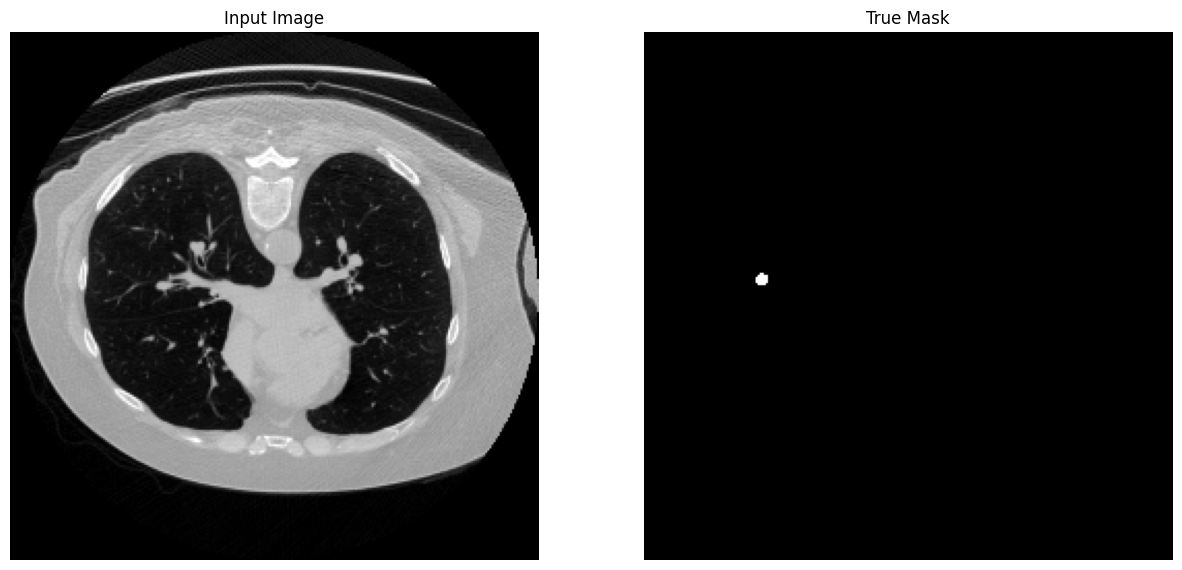

In [ ]:
# Take one slice and use it as an reference example
for batch in nas_lung.validation_ds_reduced.take(1):
  images, masks = batch
  sample_image = images[0]
  sample_mask = masks[0]
  display([sample_image, sample_mask])

In [ ]:
# Find the best architecture

# This is the fly generated by the first execution of the dfo algorithm
# a_1_model, f_1, aug_method_1 = nas_lung.search(10, 20)
f_1 = np.array([
  [ 0,  0,  1,  3,  1,  0],
  [ 1,  0,  0,  0,  6, 15],
  [ 7,  0,  0,  0,  0,  6],
  [ 1,  0,  1,  0,  0,  8],
  [ 2,  0,  0,  0,  7,  2],
  [ 3,  0,  0,  2,  4,  3],
  [ 0,  0,  1,  1,  7,  1],
])

# This is the fly generated by the second execution of the dfo algorithm
# a_2_model, f_2, aug_method_2 = nas_lung.search(10, 20)
f_2 = np.array([
  [ 7,  0,  0,  1,  5,  5],
  [ 4,  0,  0,  2,  1, 11],
  [ 4,  0,  1,  0,  6, 15],
  [ 1,  0,  0,  3,  4,  5],
  [ 0,  0,  0,  1,  5,  7],
  [ 3,  0,  0,  0,  0,  6],
  [ 5,  0,  0,  2,  5,  8],
])

#### Evaluation of different loss functions

##### Evaluate Binary Crossentropy

In [ ]:
# Get model mean metrics
bce_mean_metrics, bce_best_model = get_mean_metrics(
    tf.keras.losses.BinaryCrossentropy(), 
    nas_lung.train_ds, 
    nas_lung.validation_ds
)

Epoch 1/25
162/162 [==============================] - 19s 70ms/step - loss: 0.0103 - accuracy: 0.9995 - jaccard_coef: 0.0016 - dice_coef: 0.0022 - val_loss: 0.0033 - val_accuracy: 0.9998 - val_jaccard_coef: 9.7789e-04 - val_dice_coef: 0.0016
Epoch 2/25
162/162 [==============================] - 11s 68ms/step - loss: 0.0034 - accuracy: 0.9996 - jaccard_coef: 0.0026 - dice_coef: 0.0036 - val_loss: 0.0032 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0014 - val_dice_coef: 0.0025
Epoch 3/25
162/162 [==============================] - 11s 68ms/step - loss: 0.0032 - accuracy: 0.9996 - jaccard_coef: 0.0033 - dice_coef: 0.0048 - val_loss: 0.0017 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0025 - val_dice_coef: 0.0040
Epoch 4/25
162/162 [==============================] - 11s 67ms/step - loss: 0.0041 - accuracy: 0.9996 - jaccard_coef: 0.0029 - dice_coef: 0.0041 - val_loss: 0.0025 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0020 - val_dice_coef: 0.0036
Epoch 5/25
162/162 [========================

In [ ]:
print_mean_metrics(bce_mean_metrics)

avg train dice: 0.4913
avg val dice: 0.1143
avg train accuracy: 0.9998
avg val accuracy: 0.9998


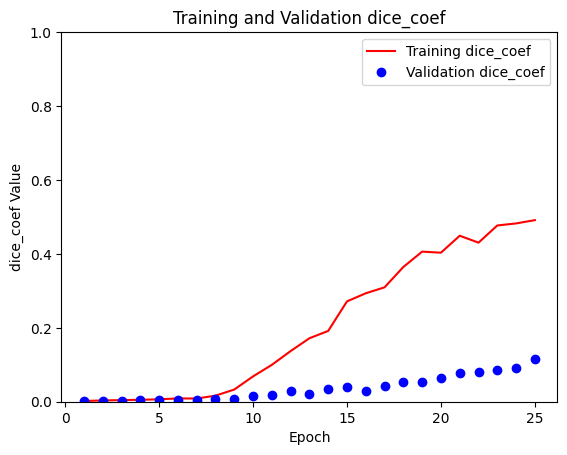

In [ ]:
plot_perf_metrics(bce_mean_metrics['history'], 'dice_coef')

1/1 [==============================] - 1s 520ms/step


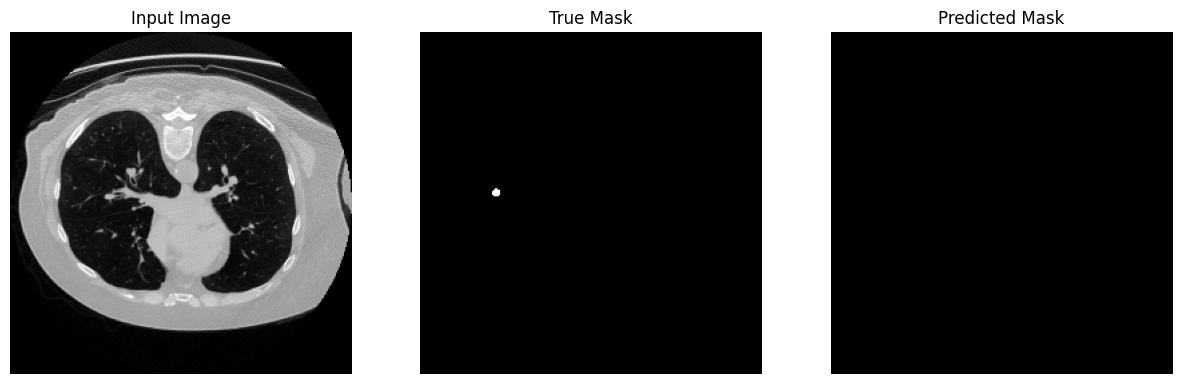

In [ ]:
show_predictions(bce_best_model)

##### Evaluate Dice Loss

In [ ]:
dice_mean_metrics, dice_best_model = get_mean_metrics(
    dice_loss,
    nas_lung.train_ds,
    nas_lung.validation_ds
)

Epoch 1/25
162/162 [==============================] - 19s 69ms/step - loss: 0.9323 - accuracy: 0.7095 - jaccard_coef: 0.0717 - dice_coef: 0.0720 - val_loss: 0.8449 - val_accuracy: 0.9998 - val_jaccard_coef: 0.1685 - val_dice_coef: 0.1685
Epoch 2/25
162/162 [==============================] - 11s 66ms/step - loss: 0.8311 - accuracy: 0.9996 - jaccard_coef: 0.1727 - dice_coef: 0.1727 - val_loss: 0.7928 - val_accuracy: 0.9998 - val_jaccard_coef: 0.2041 - val_dice_coef: 0.2041
Epoch 3/25
162/162 [==============================] - 11s 66ms/step - loss: 0.8612 - accuracy: 0.9996 - jaccard_coef: 0.1381 - dice_coef: 0.1381 - val_loss: 0.8549 - val_accuracy: 0.9998 - val_jaccard_coef: 0.1586 - val_dice_coef: 0.1586
Epoch 4/25
162/162 [==============================] - 11s 66ms/step - loss: 0.8474 - accuracy: 0.9996 - jaccard_coef: 0.1565 - dice_coef: 0.1565 - val_loss: 0.8784 - val_accuracy: 0.9998 - val_jaccard_coef: 0.1355 - val_dice_coef: 0.1355
Epoch 5/25
162/162 [============================

In [ ]:
print_mean_metrics(dice_mean_metrics)

avg train dice: 0.1476
avg val dice: 0.2048
avg train accuracy: 0.9996
avg val accuracy: 0.9998


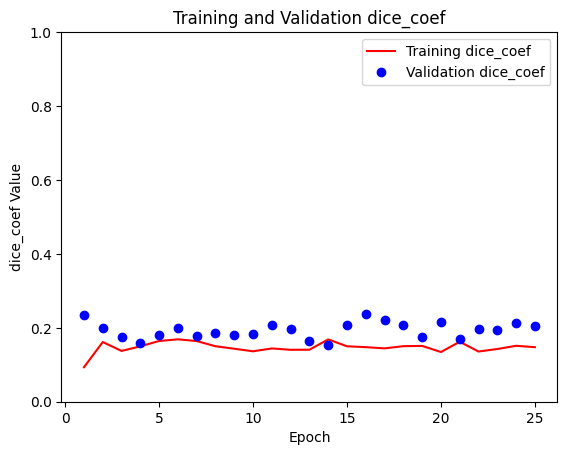

In [ ]:
plot_perf_metrics(dice_mean_metrics['history'], 'dice_coef')

1/1 [==============================] - 0s 245ms/step


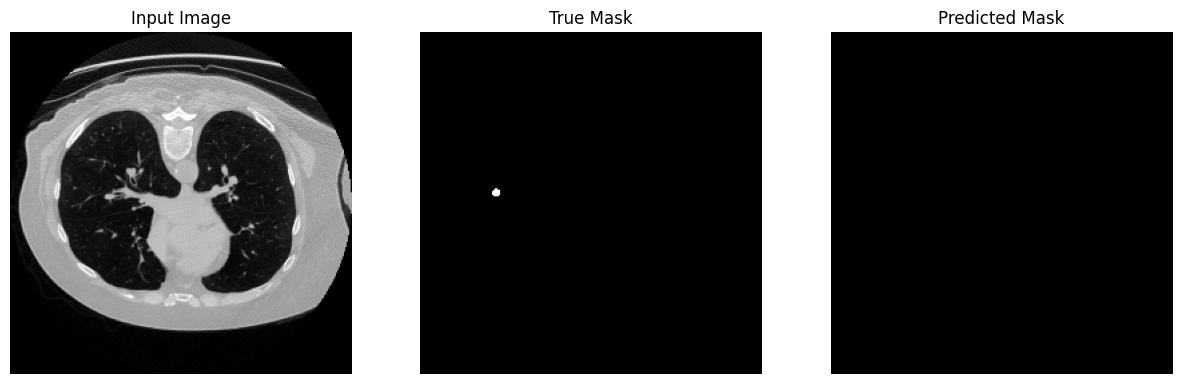

In [ ]:
show_predictions(dice_best_model)

##### Evaluate Dual Focal Loss

In [ ]:
dfl_mean_metrics, dfl_best_model = get_mean_metrics(
    BinaryDualFocalLoss(),
    nas_lung.train_ds,
    nas_lung.validation_ds
)

Epoch 1/25
162/162 [==============================] - 20s 72ms/step - loss: 0.0438 - accuracy: 0.9989 - jaccard_coef: 0.0019 - dice_coef: 0.0025 - val_loss: 0.0185 - val_accuracy: 0.9998 - val_jaccard_coef: 9.4920e-04 - val_dice_coef: 0.0017
Epoch 2/25
162/162 [==============================] - 11s 69ms/step - loss: 0.0131 - accuracy: 0.9996 - jaccard_coef: 0.0063 - dice_coef: 0.0076 - val_loss: 0.0075 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0057 - val_dice_coef: 0.0062
Epoch 3/25
162/162 [==============================] - 11s 69ms/step - loss: 0.0130 - accuracy: 0.9996 - jaccard_coef: 0.0050 - dice_coef: 0.0067 - val_loss: 0.0136 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0016 - val_dice_coef: 0.0030
Epoch 4/25
162/162 [==============================] - 11s 69ms/step - loss: 0.0110 - accuracy: 0.9996 - jaccard_coef: 0.0051 - dice_coef: 0.0081 - val_loss: 0.0202 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0024 - val_dice_coef: 0.0046
Epoch 5/25
162/162 [========================

In [ ]:
print_mean_metrics(dfl_mean_metrics)

avg train dice: 0.5267
avg val dice: 0.0747
avg train accuracy: 0.9998
avg val accuracy: 0.9998


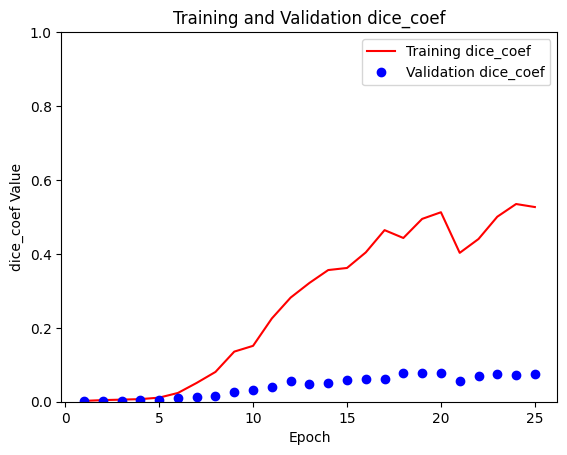

In [ ]:
plot_perf_metrics(dfl_mean_metrics['history'], 'dice_coef')

1/1 [==============================] - 0s 239ms/step


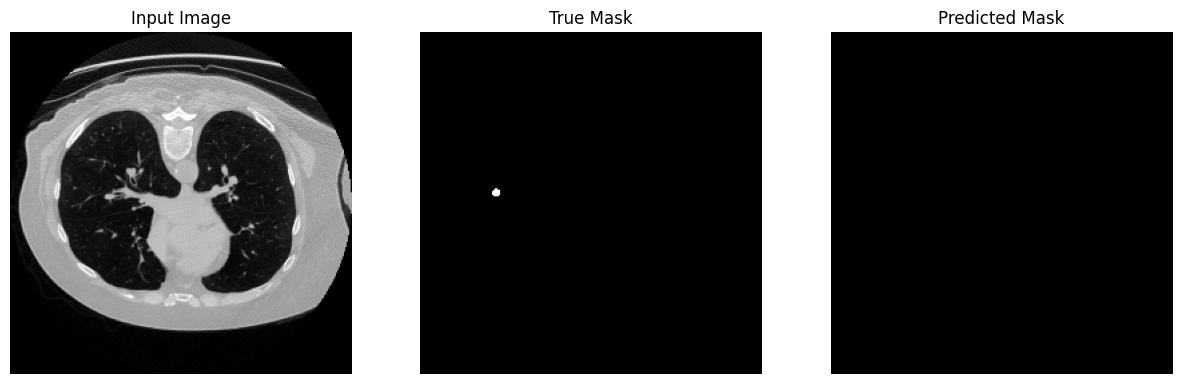

In [ ]:
show_predictions(dfl_best_model)

#### Evaluation of two combinations of a data set

Check which data set it is better to use
- Data set with all examples
- Data set with examples where masks have non-zero values

##### Model with full data set passed to the training process

In [ ]:
dfl_full_mean_metrics, dfl_full_best_model = get_mean_metrics(
    BinaryDualFocalLoss(),
    nas_lung.train_ds,
    nas_lung.validation_ds
)

Epoch 1/25
162/162 [==============================] - 19s 71ms/step - loss: 0.2277 - accuracy: 0.9752 - jaccard_coef: 0.0014 - dice_coef: 0.0017 - val_loss: 0.0220 - val_accuracy: 0.9998 - val_jaccard_coef: 6.7203e-04 - val_dice_coef: 0.0012
Epoch 2/25
162/162 [==============================] - 11s 68ms/step - loss: 0.0132 - accuracy: 0.9996 - jaccard_coef: 0.0021 - dice_coef: 0.0029 - val_loss: 0.0167 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0011 - val_dice_coef: 0.0020
Epoch 3/25
162/162 [==============================] - 11s 68ms/step - loss: 0.0120 - accuracy: 0.9996 - jaccard_coef: 0.0026 - dice_coef: 0.0040 - val_loss: 0.0169 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0015 - val_dice_coef: 0.0028
Epoch 4/25
162/162 [==============================] - 11s 68ms/step - loss: 0.0117 - accuracy: 0.9996 - jaccard_coef: 0.0029 - dice_coef: 0.0045 - val_loss: 0.0095 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0022 - val_dice_coef: 0.0038
Epoch 5/25
162/162 [========================

In [ ]:
print_mean_metrics(dfl_full_mean_metrics)

avg train dice: 0.4986
avg val dice: 0.06
avg train accuracy: 0.9998
avg val accuracy: 0.9998


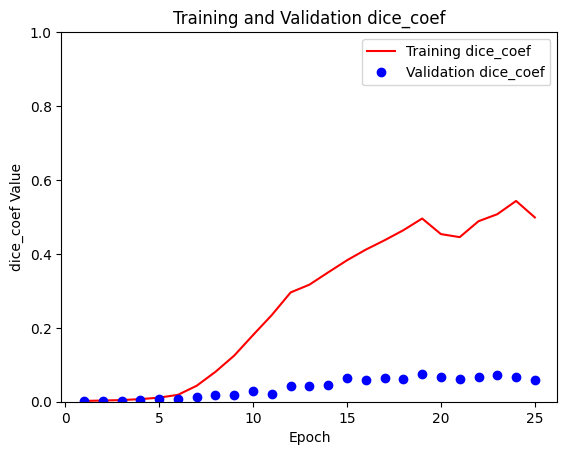

In [ ]:
plot_perf_metrics(dfl_full_mean_metrics['history'], 'dice_coef')

1/1 [==============================] - 0s 252ms/step


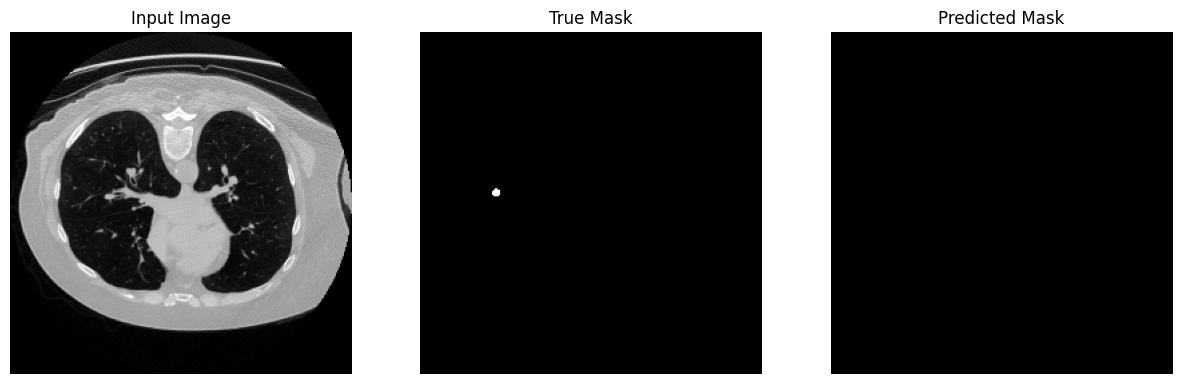

In [ ]:
show_predictions(dfl_full_best_model)

##### Model with reduced data set passed to the training process

In [ ]:
dfl_reduced_mean_metrics, dfl_reduced_best_model = get_mean_metrics(
    BinaryDualFocalLoss(),
    nas_lung.train_ds_reduced,
    nas_lung.validation_ds_reduced
)

Epoch 1/25
19/19 [==============================] - 12s 155ms/step - loss: 0.8178 - accuracy: 0.9455 - jaccard_coef: 7.9314e-04 - dice_coef: 0.0015 - val_loss: 0.4242 - val_accuracy: 0.9978 - val_jaccard_coef: 9.5313e-04 - val_dice_coef: 0.0019
Epoch 2/25
19/19 [==============================] - 1s 56ms/step - loss: 0.1322 - accuracy: 0.9954 - jaccard_coef: 0.0048 - dice_coef: 0.0094 - val_loss: 0.1228 - val_accuracy: 0.9978 - val_jaccard_coef: 0.0063 - val_dice_coef: 0.0124
Epoch 3/25
19/19 [==============================] - 1s 56ms/step - loss: 0.0937 - accuracy: 0.9954 - jaccard_coef: 0.0125 - dice_coef: 0.0245 - val_loss: 0.1415 - val_accuracy: 0.9978 - val_jaccard_coef: 0.0077 - val_dice_coef: 0.0152
Epoch 4/25
19/19 [==============================] - 1s 56ms/step - loss: 0.0841 - accuracy: 0.9954 - jaccard_coef: 0.0173 - dice_coef: 0.0338 - val_loss: 0.1002 - val_accuracy: 0.9978 - val_jaccard_coef: 0.0092 - val_dice_coef: 0.0182
Epoch 5/25
19/19 [==============================] 

In [ ]:
print_mean_metrics(dfl_reduced_mean_metrics)

avg train dice: 0.6008
avg val dice: 0.1761
avg train accuracy: 0.9977
avg val accuracy: 0.9975


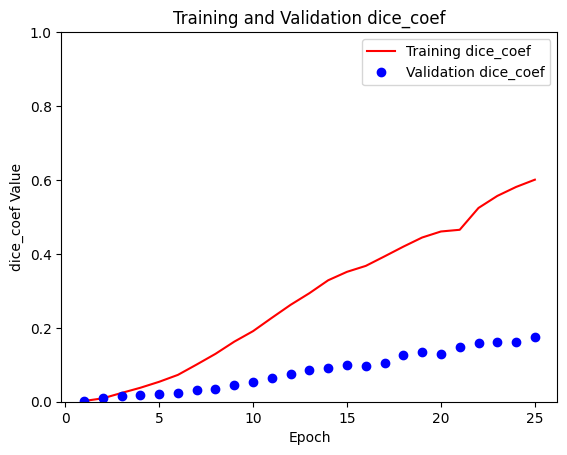

In [ ]:
plot_perf_metrics(dfl_reduced_mean_metrics['history'], 'dice_coef')

1/1 [==============================] - 0s 242ms/step


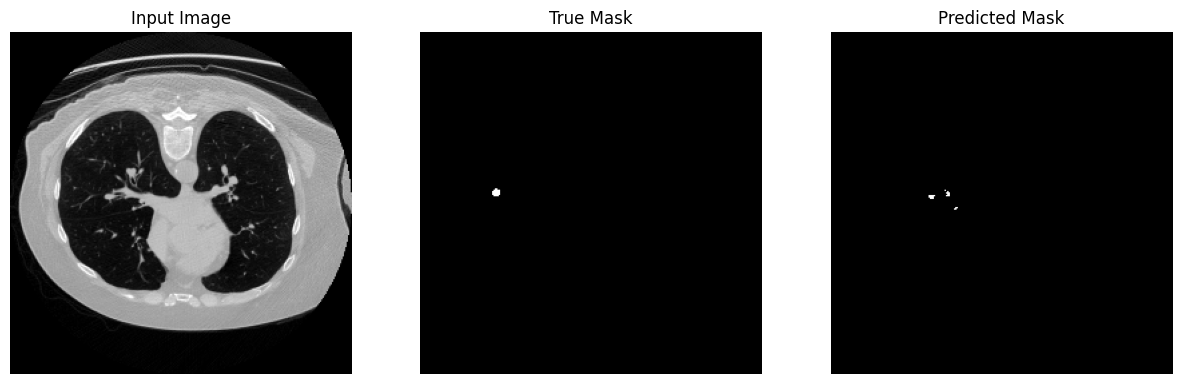

In [ ]:
show_predictions(dfl_reduced_best_model)

#### Check whether reduced data set changes anything in selecting the best architecture

In [ ]:
smaller_train_ds = nas_lung.train_ds.take(272)
smaller_val_ds = nas_lung.validation_ds.take(68)

##### Get metrics from the first fly

In [ ]:
dfl_full_mean_metrics = get_mean_metrics(
    BinaryDualFocalLoss(), 
    nas_lung.train_ds, 
    nas_lung.validation_ds, 
    fly=f_1
)

dfl_part_mean_metrics = get_mean_metrics(
    BinaryDualFocalLoss(),
    smaller_train_ds,
    smaller_val_ds,
    fly=f_1
)

Epoch 1/25
162/162 [==============================] - 38s 125ms/step - loss: 0.2762 - accuracy: 0.9906 - jaccard_coef: 0.0058 - dice_coef: 0.0059 - val_loss: 0.0101 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0104 - val_dice_coef: 0.0104
Epoch 2/25
162/162 [==============================] - 18s 111ms/step - loss: 0.0188 - accuracy: 0.9996 - jaccard_coef: 0.0041 - dice_coef: 0.0044 - val_loss: 0.0060 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0024 - val_dice_coef: 0.0030
Epoch 3/25
162/162 [==============================] - 18s 111ms/step - loss: 0.0115 - accuracy: 0.9996 - jaccard_coef: 0.0030 - dice_coef: 0.0046 - val_loss: 0.0061 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0057 - val_dice_coef: 0.0060
Epoch 4/25
162/162 [==============================] - 18s 111ms/step - loss: 0.0101 - accuracy: 0.9996 - jaccard_coef: 0.0056 - dice_coef: 0.0092 - val_loss: 0.0055 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0052 - val_dice_coef: 0.0091
Epoch 5/25
162/162 [========================

In [ ]:
print('metrics for dfl_full_mean_metrics')
metrics, model = dfl_full_mean_metrics
print_mean_metrics(metrics)

print('metrics for dfl_part_mean_metrics')
metrics_1, model_1 = dfl_part_mean_metrics
print_mean_metrics(metrics_1)

metrics for dfl_full_mean_metrics
avg train dice: 0.4744
avg val dice: 0.1901
avg train accuracy: 0.9998
avg val accuracy: 0.9998
metrics for dfl_part_mean_metrics
avg train dice: 0.5146
avg val dice: 0.1593
avg train accuracy: 0.9998
avg val accuracy: 0.9998


##### Get the metrics from the second fly

In [ ]:
dfl_full_mean_metrics, dfl_full_mean_model = get_mean_metrics(
    BinaryDualFocalLoss(), 
    nas_lung.train_ds, 
    nas_lung.validation_ds, 
    fly=f_2
)

dfl_part_mean_metrics, dfl_part_mean_model = get_mean_metrics(
    BinaryDualFocalLoss(),
    smaller_train_ds,
    smaller_val_ds,
    fly=f_2
)

Epoch 1/25
162/162 [==============================] - 42s 154ms/step - loss: 0.4721 - accuracy: 0.9996 - jaccard_coef: 5.3206e-04 - dice_coef: 9.3247e-04 - val_loss: 0.0111 - val_accuracy: 0.9998 - val_jaccard_coef: 6.1445e-04 - val_dice_coef: 7.8376e-04
Epoch 2/25
162/162 [==============================] - 24s 146ms/step - loss: 0.0142 - accuracy: 0.9996 - jaccard_coef: 0.0014 - dice_coef: 0.0021 - val_loss: 0.0070 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0017 - val_dice_coef: 0.0023
Epoch 3/25
162/162 [==============================] - 24s 146ms/step - loss: 0.0126 - accuracy: 0.9996 - jaccard_coef: 0.0028 - dice_coef: 0.0047 - val_loss: 0.0057 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0035 - val_dice_coef: 0.0058
Epoch 4/25
162/162 [==============================] - 24s 146ms/step - loss: 0.0113 - accuracy: 0.9996 - jaccard_coef: 0.0046 - dice_coef: 0.0081 - val_loss: 0.0060 - val_accuracy: 0.9998 - val_jaccard_coef: 0.0045 - val_dice_coef: 0.0078
Epoch 5/25
162/162 [========

KeyboardInterrupt: ignored

In [ ]:
print('metrics for dfl_full_mean_metrics')
print_mean_metrics(dfl_full_mean_metrics)

print('metrics for dfl_part_mean_metrics')
print_mean_metrics(dfl_part_mean_metrics)

#### Compare f_1, f_2 against baseline model

##### Evaluate the baseline model

In [ ]:
baseline_mean_metrics, best_baseline_model = get_mean_metrics(
    BinaryDualFocalLoss(), 
    nas_lung.train_ds, 
    nas_lung.validation_ds,
    epochs=50
)

In [ ]:
print_mean_metrics(baseline_mean_metrics)

In [ ]:
plot_perf_metrics(baseline_mean_metrics['history'])

In [ ]:
best_baseline_model.summary()

In [ ]:
show_predictions(best_baseline_model)

In [ ]:
tf.keras.utils.plot_model(best_baseline_model, show_shapes=True)

##### Evaluate DFO search output (first fly)

In [ ]:
a_1_mean_metrics, a_1_model = get_mean_metrics(
    BinaryDualFocalLoss(), 
    nas_lung.train_ds, 
    nas_lung.validation_ds, 
    fly=f_1,
    epochs=50
)

In [ ]:
print_mean_metrics(a_1_mean_metrics)

In [ ]:
plot_perf_metrics(a_1_mean_metrics['history'])

In [ ]:
a_1_model.summary()

In [ ]:
show_predictions(a_1_model)

In [ ]:
inputs = tf.keras.layers.Input((256, 256, 1))
outputs = map_fly_to_architecture(f_1, inputs)
a_1_model = tf.keras.Model(inputs=inputs, outputs=outputs)
a_1_model.compile(
    optimizer='adam',
    loss=BinaryDualFocalLoss(),
    metrics=[dice_coef, jaccard_coef, 'accuracy']
)

tf.keras.utils.plot_model(a_1_model, show_shapes=True)

##### Evaluate DFO search output (second fly)

In [ ]:
a_2_mean_metrics, a_2_model = get_mean_metrics(
    BinaryDualFocalLoss(), 
    nas_lung.train_ds, 
    nas_lung.validation_ds, 
    fly=f_2,
    epochs=50
)

In [ ]:
print_mean_metrics(a_2_mean_metrics)

In [ ]:
plot_perf_metrics(a_2_mean_metrics['history'])

In [ ]:
a_2_model.summary()

In [ ]:
show_predictions(a_2_model)

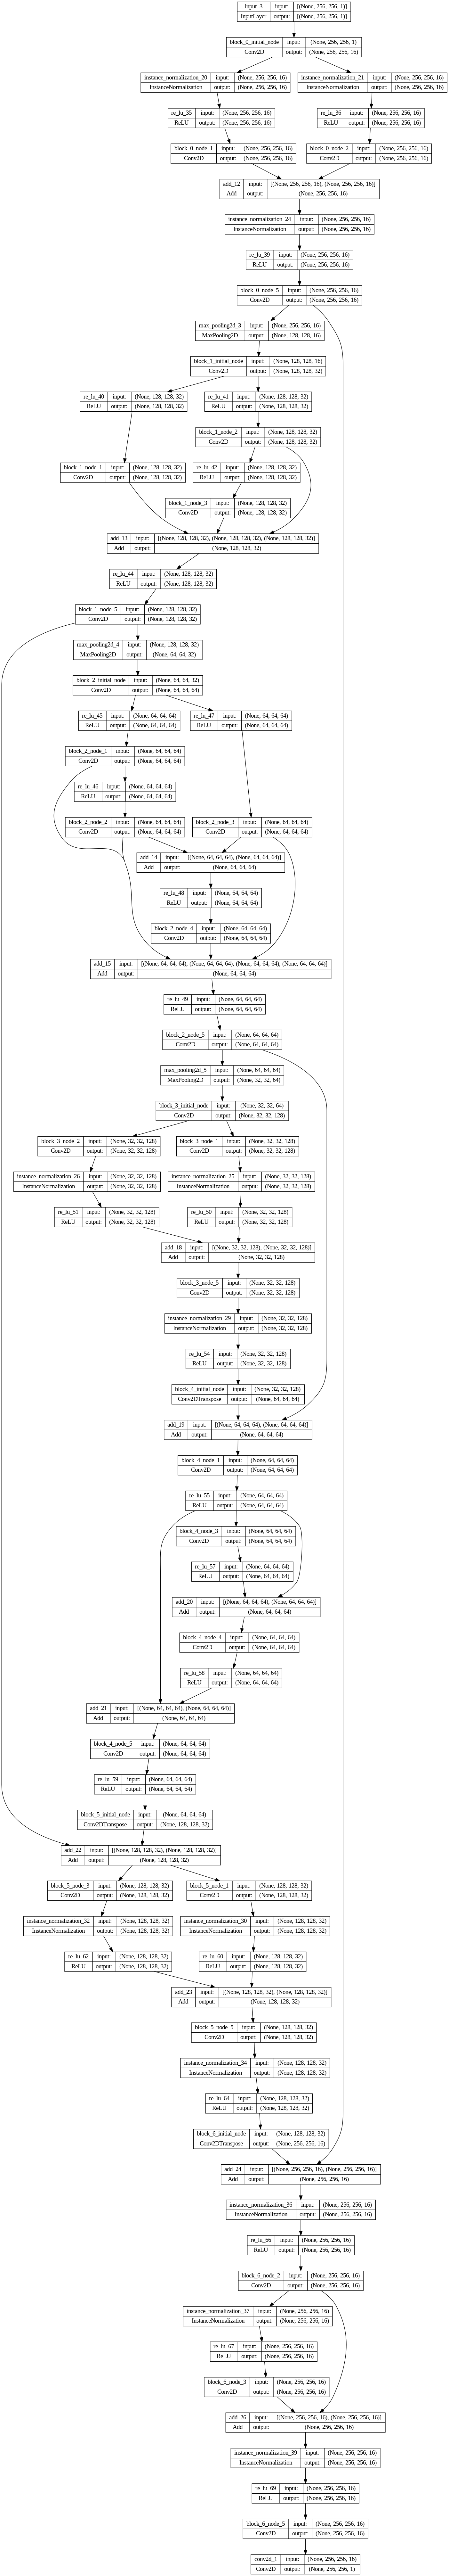

In [ ]:
inputs = tf.keras.layers.Input((256, 256, 1))
outputs = map_fly_to_architecture(f_2, inputs)
a_2_model = tf.keras.Model(inputs=inputs, outputs=outputs)
a_2_model.compile(
    optimizer='adam',
    loss=BinaryDualFocalLoss(),
    metrics=[dice_coef, jaccard_coef, 'accuracy']
)

tf.keras.utils.plot_model(a_2_model, show_shapes=True)

#### Evaluate data augmentation search method

Compare whether it is better or worse than the model without augmentation applied

In [ ]:
# Find data augmentation technique for that architecture
inputs = tf.keras.Input((256, 256, 1))
aug_tech = adjust_agumentation(inputs, nas_lung.train_ds, nas_lung.validation_ds, f_1)

In [ ]:
augmented_inputs = aug_tech(inputs)

architecture = map_fly_to_architecture(f_1, augmented_inputs)

model = tf.keras.Model(
    inputs=inputs,
    outputs=architecture
)

model.compile(
  optimizer='adam',
  loss=BinaryDualFocalLoss(),
  metrics=[dice_coef, jaccard_coef, 'accuracy']
)

model.fit(
  nas_lung.train_ds,
  validation_data=nas_lung.validation_ds,
  epochs=50,
)


In [ ]:
augmented_mean_metrics = get_mean_metrics(
    BinaryDualFocalLoss(), 
    train_ds, 
    validation_ds, 
    f_1, 
    augmentation_technique=aug_tech
)

### Evaluate Liver Data Set

In [18]:
# initialise class
nas_liver = NasMedSeg(input_shape=(256, 256, 1))

# Load the data
liver_ds_path = './drive/MyDrive/liver_dataset/liver_smaller.zip'
nas_liver.load(liver_ds_path, 64)

scans: 51 / 51


In [19]:
# f_3 was returned from the execution of the search method. 
# Because it takes more than 4 hours to run the search
# The returned fly is stored for future experiments

# a_3, f_3, _ = nas_liver.search(10, 20)
# f_3 = np.array([
#   [ 0,  0,  1,  0,  7,  6],
#   [ 5,  0,  0,  2,  7, 15],
#   [ 5,  0,  0,  2,  3,  9],
#   [ 3,  0,  0,  0,  2,  7],
#   [ 6,  0,  0,  3,  1, 15],
#   [ 1,  0,  1,  3,  0,  0],
#   [ 0,  0,  1,  3,  2,  0],
# ])

# f_4 was returned from the execution of the search method. 
# Because it takes more than 4 hours to run the search
# The returned fly is stored for future experiments

# a_4, f_4, _ = nas_liver.search(10, 20)
f_4 = np.array([
  [12,  0,  1,  0,  4, 11],
  [13,  0,  0,  2,  7,  3],
  [ 6,  0,  1,  0,  2,  7],
  [10,  0,  0,  0,  3, 12],
  [15,  0,  0,  3,  4, 10],
  [10,  0,  0,  1,  4, 12],
  [ 5,  0,  1,  0,  5, 11],
])
# print(f_4)

Get sample image and sample mask

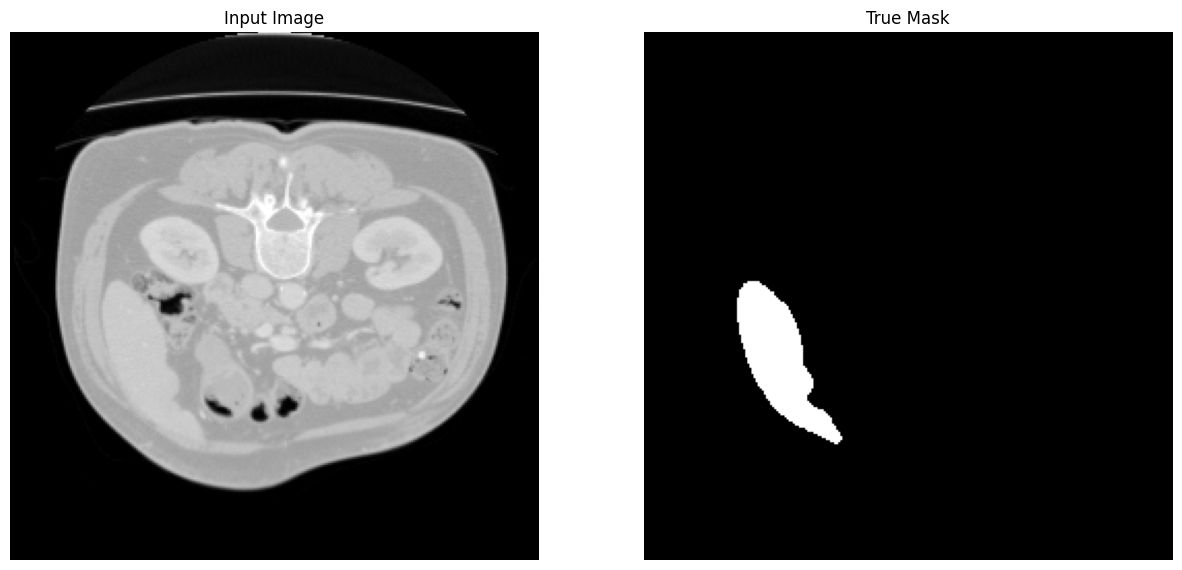

In [20]:
# Take one slice and use it as an reference example
for batch in nas_liver.validation_ds_reduced.take(1):
  images, masks = batch
  sample_image = images[0]
  sample_mask = masks[0]
  display([sample_image, sample_mask])

##### Baseline model

In [ ]:
baseline_mean_metrics, baseline_model = get_mean_metrics(
    BinaryDualFocalLoss(), 
    nas_liver.train_ds, 
    nas_liver.validation_ds, 
    epochs=50
)

In [ ]:
print_mean_metrics(baseline_mean_metrics)

In [ ]:
plot_perf_metrics(baseline_mean_metrics['history'])

In [ ]:
show_predictions(baseline_model)

In [ ]:
baseline_model.summary()

##### architecture **$A_3$** resulted from the best fly returned from the first invokation of the DFO method

In [ ]:
a_3_mean_metrics, a_3_model = get_mean_metrics(
    BinaryDualFocalLoss(),
    nas_liver.train_ds,
    nas_liver.validation_ds,
    fly=f_3,
    epochs = 50
)

In [ ]:
print_mean_metrics(a_3_mean_metrics)

In [ ]:
plot_perf_metrics(a_3_mean_metrics['history'])

In [ ]:
show_predictions(a_3_model)

In [ ]:
a_3_model.summary()

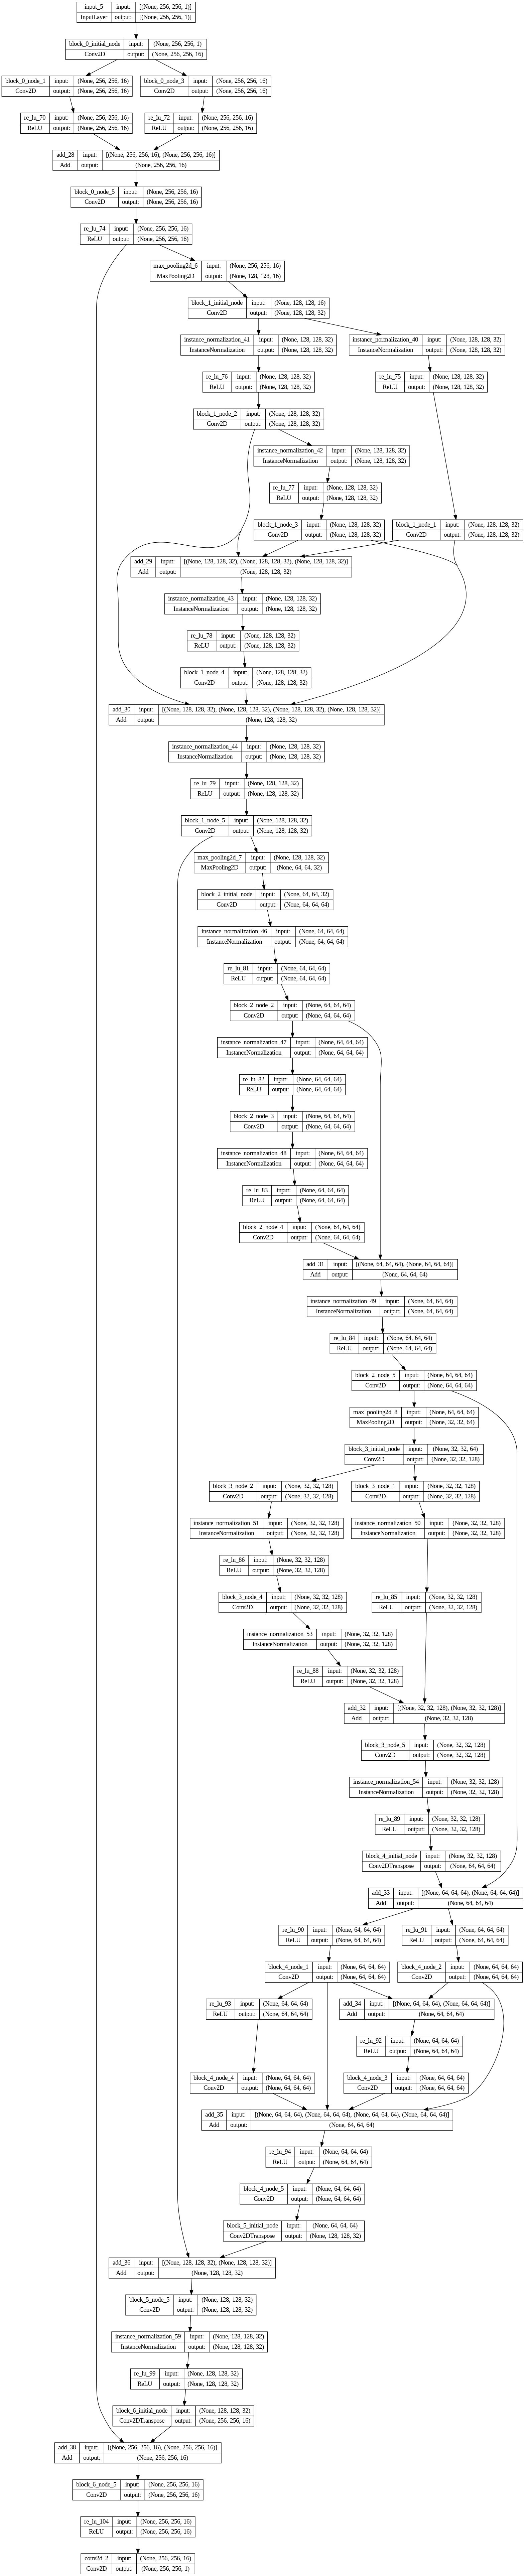

In [ ]:
inputs = tf.keras.layers.Input((256, 256, 1))
outputs = map_fly_to_architecture(f_3, inputs)
a_3_model = tf.keras.Model(inputs=inputs, outputs=outputs)
a_3_model.compile(
    optimizer='adam',
    loss=BinaryDualFocalLoss(),
    metrics=[dice_coef, jaccard_coef, 'accuracy']
)

tf.keras.utils.plot_model(a_3_model, show_shapes=True)

##### architecture **$A_4$** resulted from the best fly returned from the first invokation of the DFO method

In [21]:
a_4_mean_metrics, a_4_model = get_mean_metrics(
    BinaryDualFocalLoss(),
    nas_liver.train_ds,
    nas_liver.validation_ds,
    fly=f_4,
    epochs = 50 
)

Epoch 1/50
131/131 [==============================] - 50s 121ms/step - loss: 0.4022 - accuracy: 0.9620 - jaccard_coef: 0.1559 - dice_coef: 0.2590 - val_loss: 0.1901 - val_accuracy: 0.9833 - val_jaccard_coef: 0.0633 - val_dice_coef: 0.1186
Epoch 2/50
131/131 [==============================] - 13s 101ms/step - loss: 0.1814 - accuracy: 0.9803 - jaccard_coef: 0.4264 - dice_coef: 0.5866 - val_loss: 0.0889 - val_accuracy: 0.9922 - val_jaccard_coef: 0.3812 - val_dice_coef: 0.5475
Epoch 3/50
131/131 [==============================] - 13s 101ms/step - loss: 0.1201 - accuracy: 0.9875 - jaccard_coef: 0.5762 - dice_coef: 0.7256 - val_loss: 0.0457 - val_accuracy: 0.9952 - val_jaccard_coef: 0.6329 - val_dice_coef: 0.7741
Epoch 4/50
131/131 [==============================] - 13s 101ms/step - loss: 0.0826 - accuracy: 0.9915 - jaccard_coef: 0.6961 - dice_coef: 0.8196 - val_loss: 0.0443 - val_accuracy: 0.9954 - val_jaccard_coef: 0.6477 - val_dice_coef: 0.7837
Epoch 5/50
131/131 [========================

In [22]:
print_mean_metrics(a_4_mean_metrics)

avg train dice: 0.9426
avg val dice: 0.9121
avg train accuracy: 0.9979
avg val accuracy: 0.998


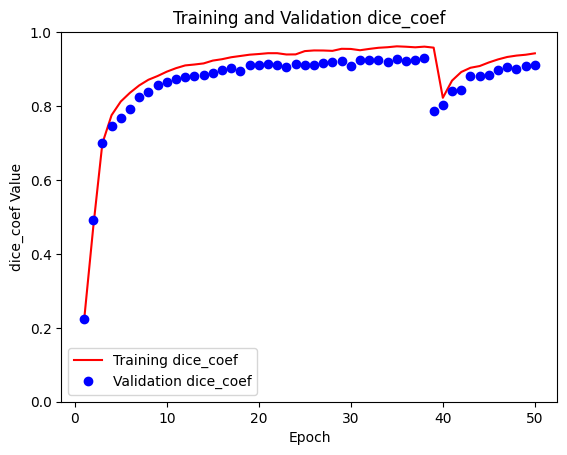

In [24]:
plot_perf_metrics(a_4_mean_metrics['history'], 'dice_coef')

1/1 [==============================] - 1s 1s/step


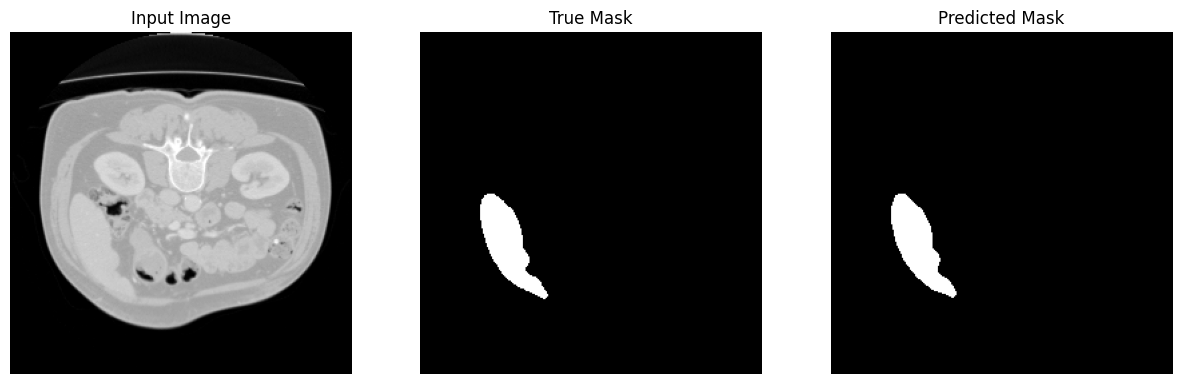

In [25]:
show_predictions(a_4_model)

In [ ]:
a_4_model.summary()

In [ ]:
inputs = tf.keras.layers.Input((256, 256, 1))
outputs = map_fly_to_architecture(f_4, inputs)
a_4_model = tf.keras.Model(inputs=inputs, outputs=outputs)
a_4_model.compile(
    optimizer='adam',
    loss=BinaryDualFocalLoss(),
    metrics=[dice_coef, jaccard_coef, 'accuracy']
)

tf.keras.utils.plot_model(a_4_model, show_shapes=True)

In [ ]:
a_4_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 block_0_initial_node (Conv2D)  (None, 256, 256, 16  416         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu (ReLU)                   (None, 256, 256, 16  0           ['block_0_initial_node[0][0]']   
                                )                                                             

1/1 [==============================] - 0s 28ms/step


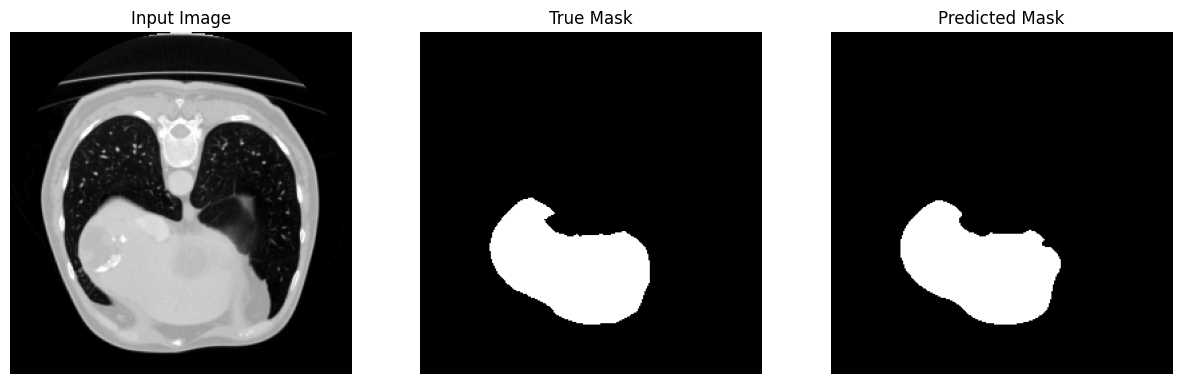

1/1 [==============================] - 0s 26ms/step


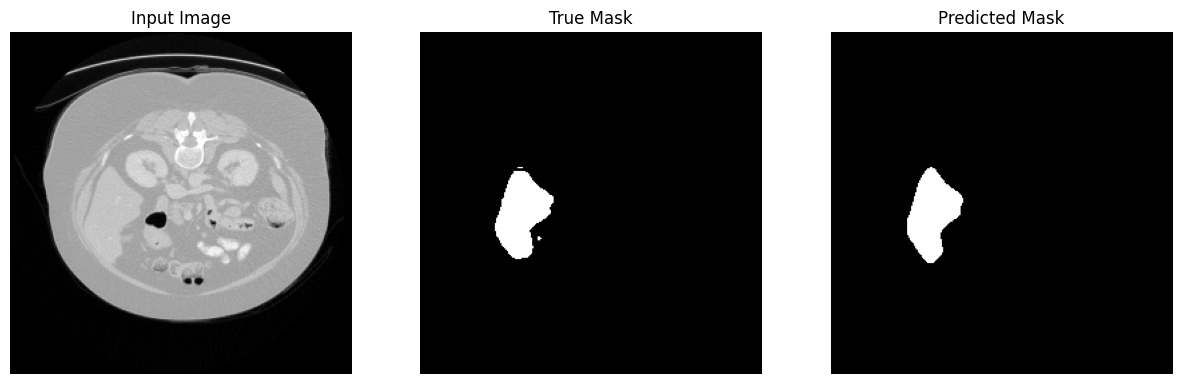

1/1 [==============================] - 0s 25ms/step


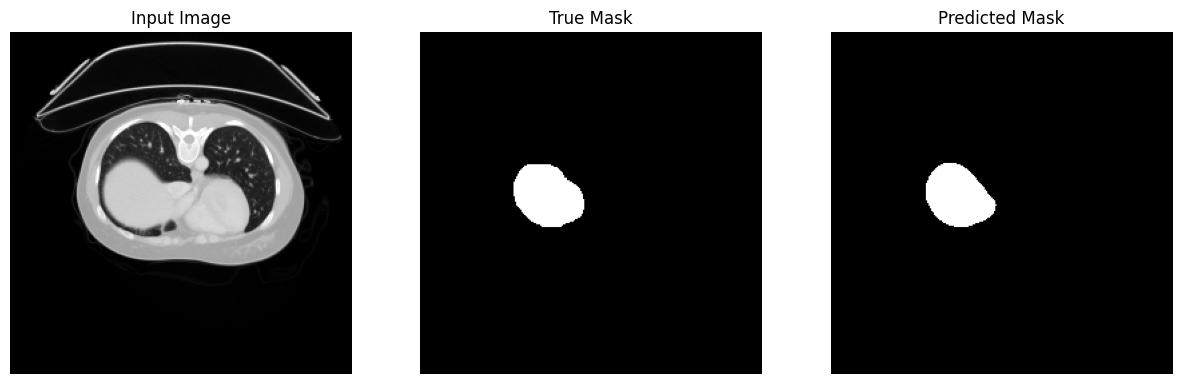

1/1 [==============================] - 0s 25ms/step


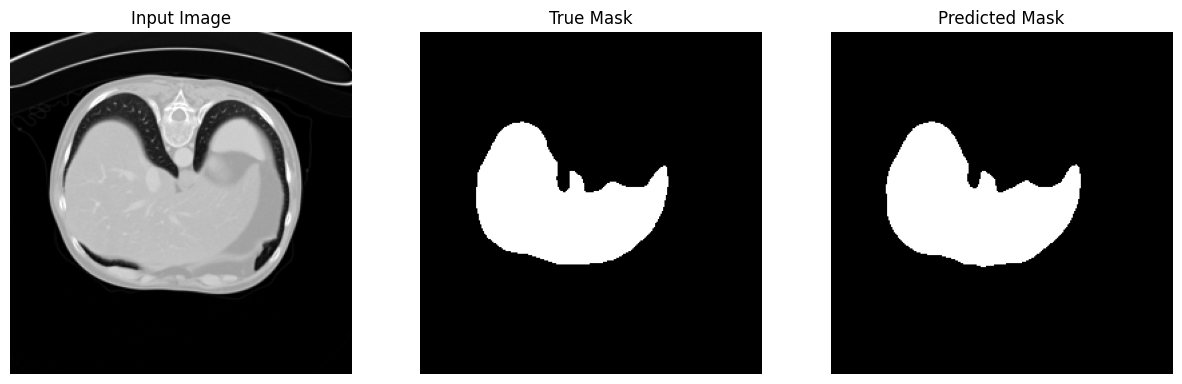

1/1 [==============================] - 0s 25ms/step


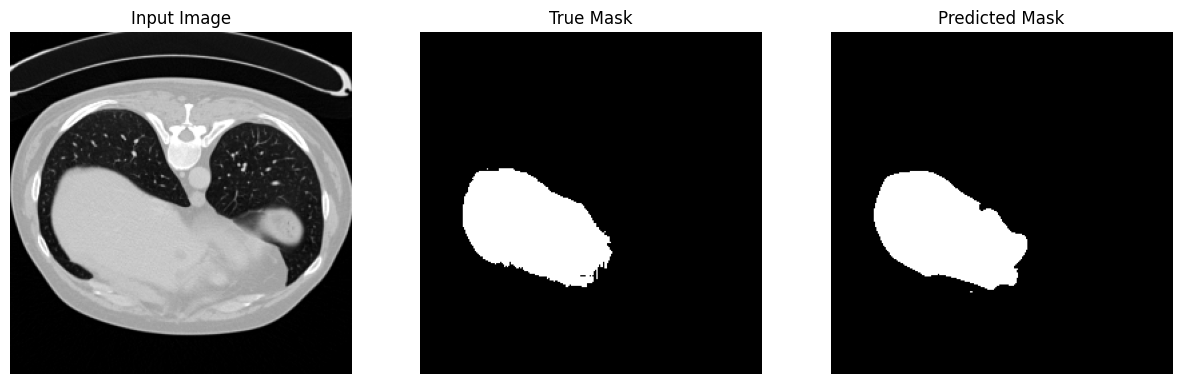

1/1 [==============================] - 0s 26ms/step


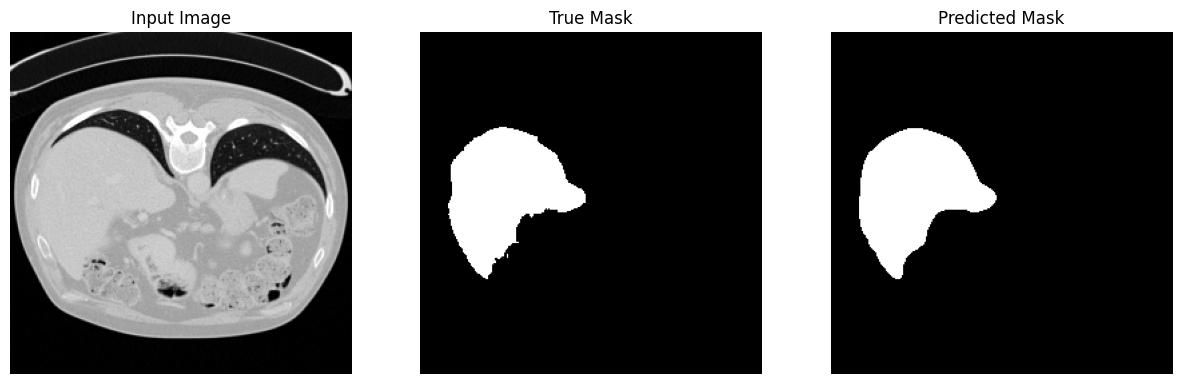

1/1 [==============================] - 0s 26ms/step


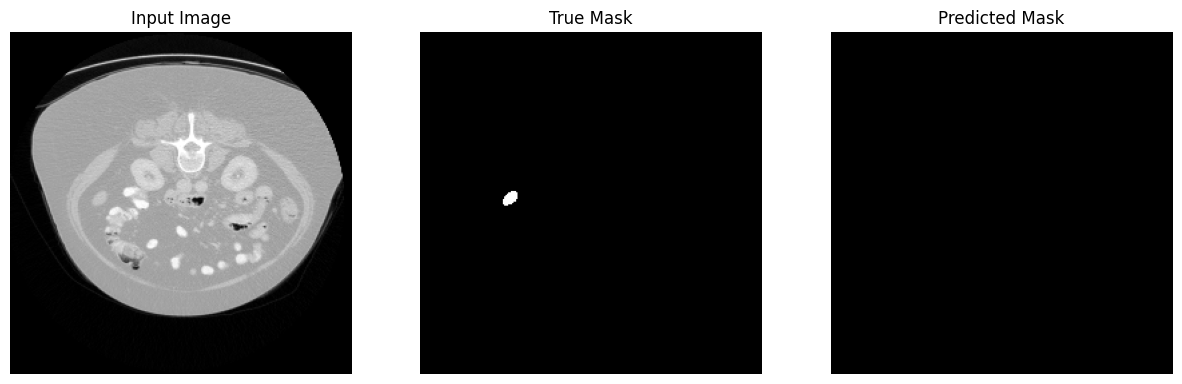

1/1 [==============================] - 0s 25ms/step


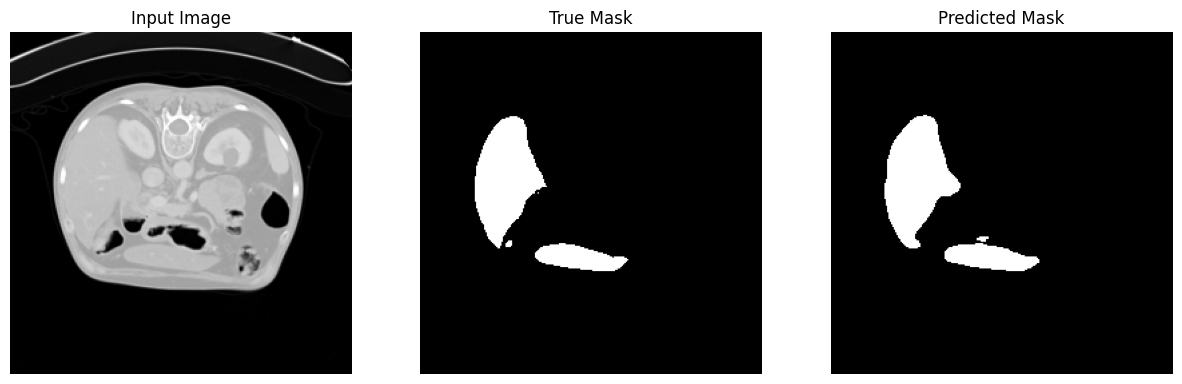

1/1 [==============================] - 0s 25ms/step


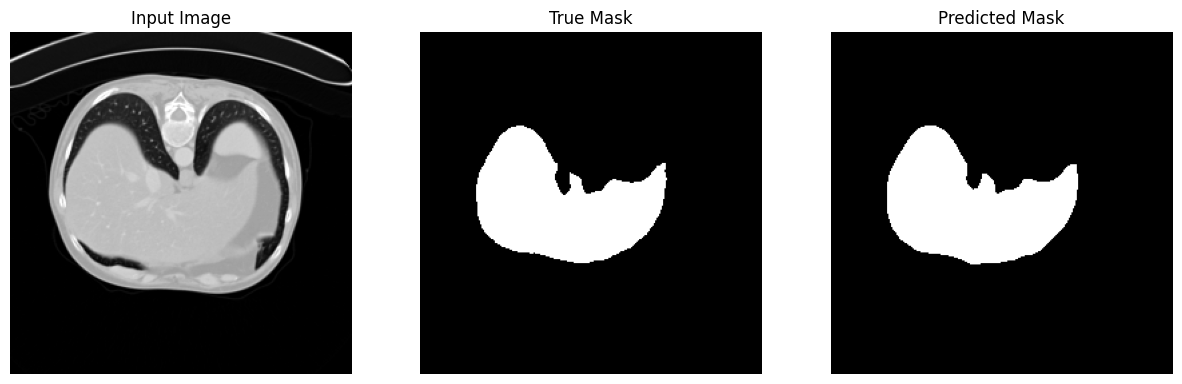

1/1 [==============================] - 0s 25ms/step


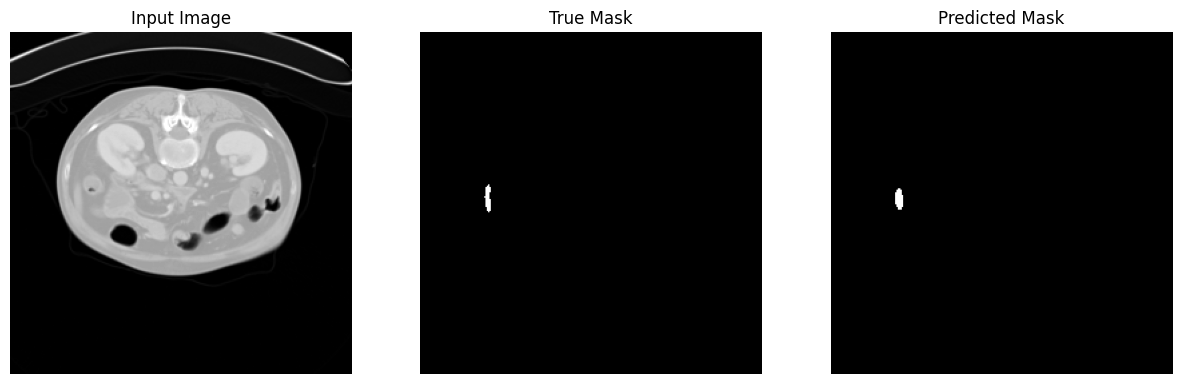

1/1 [==============================] - 0s 25ms/step


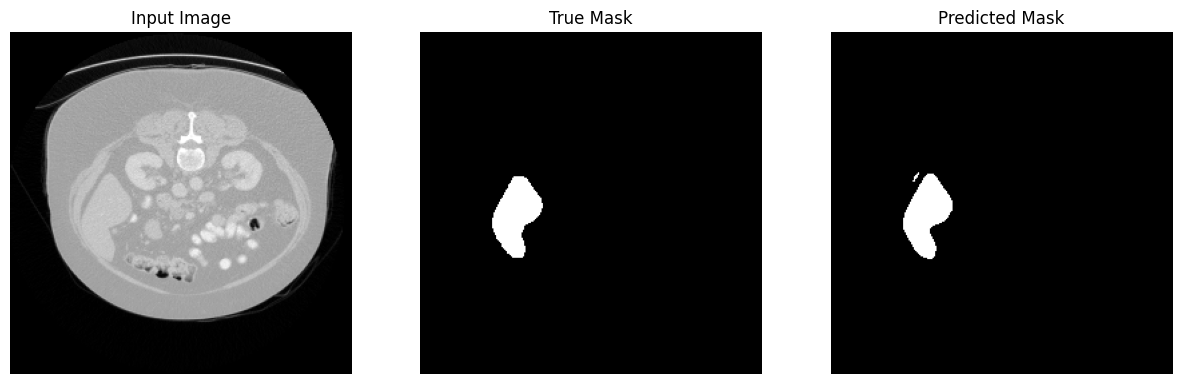

1/1 [==============================] - 0s 25ms/step


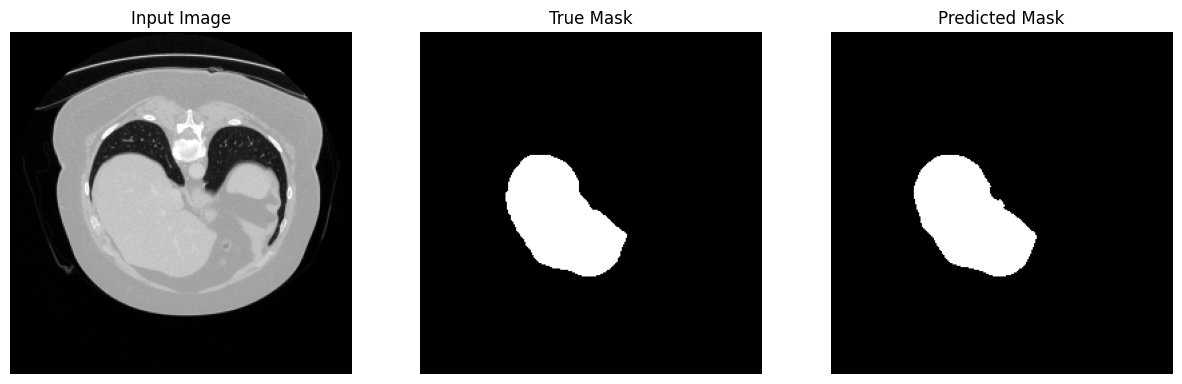

1/1 [==============================] - 0s 24ms/step


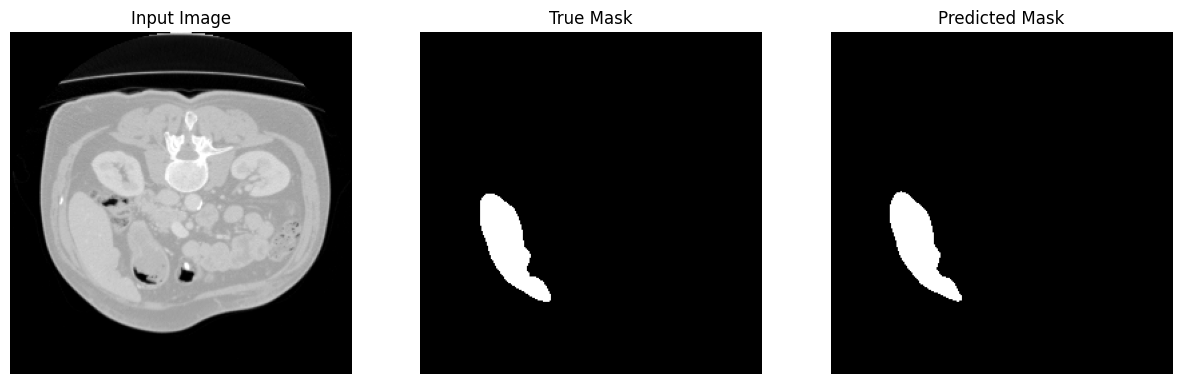

1/1 [==============================] - 0s 25ms/step


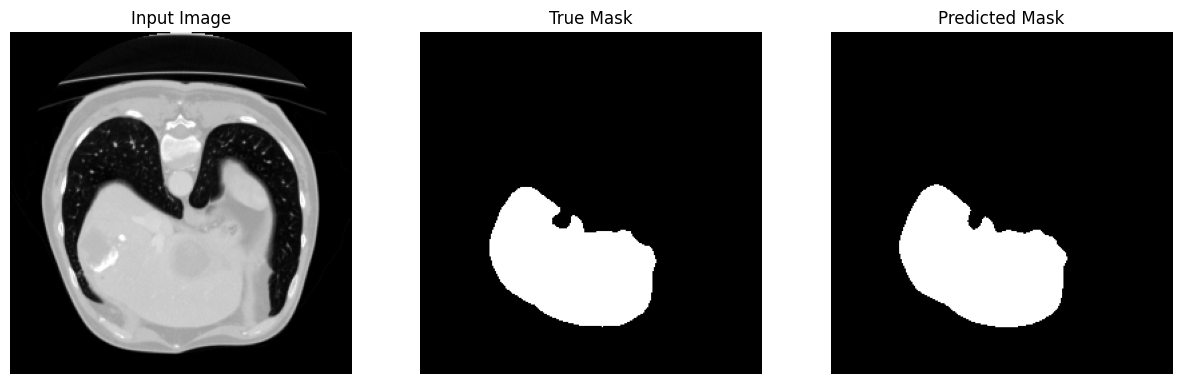

1/1 [==============================] - 0s 25ms/step


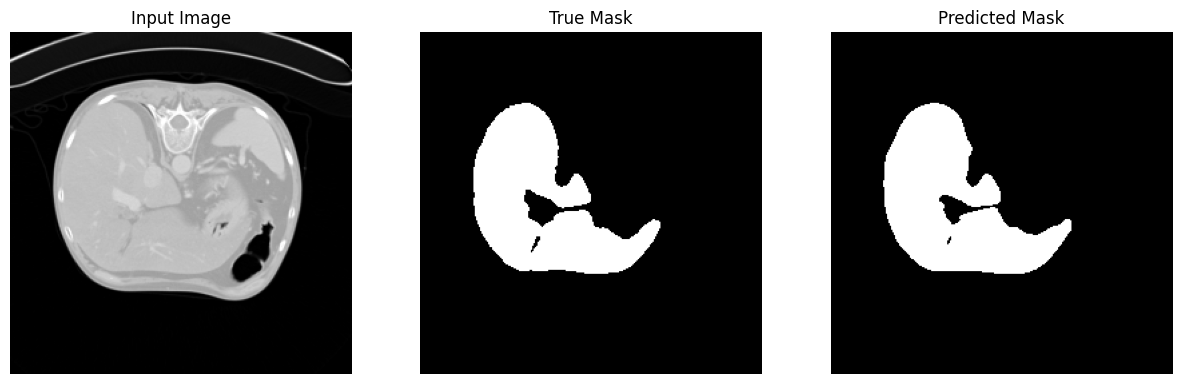

1/1 [==============================] - 0s 30ms/step


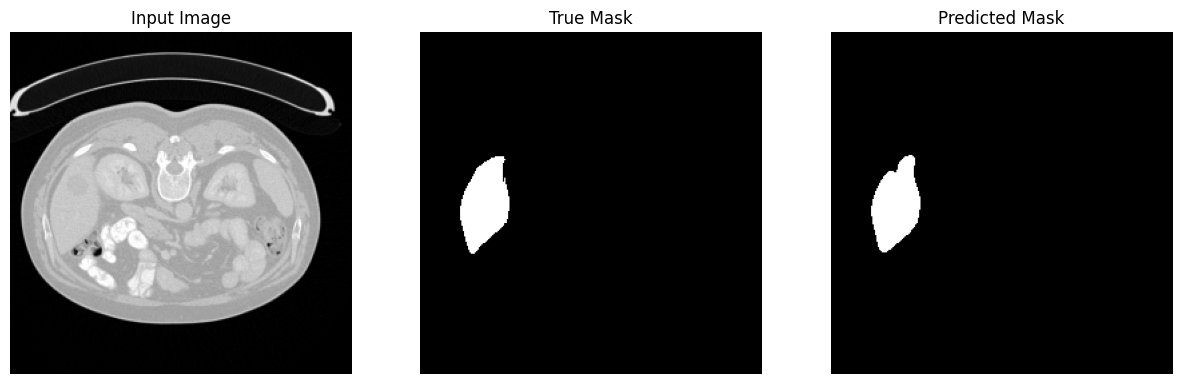

In [26]:
for batch in nas_liver.validation_ds_reduced.take(1):
  images, masks = batch
  for i in range(len(images)):
    sample_image = images[i]
    sample_mask = masks[i]
    show_predictions(a_4_model)